# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

## Step 1: Create an account with Kaggle

### Create Kaggle Account and download API key
Below is example of steps to get the API username and key. Each student will have their own username and key.

1. Open account settings.
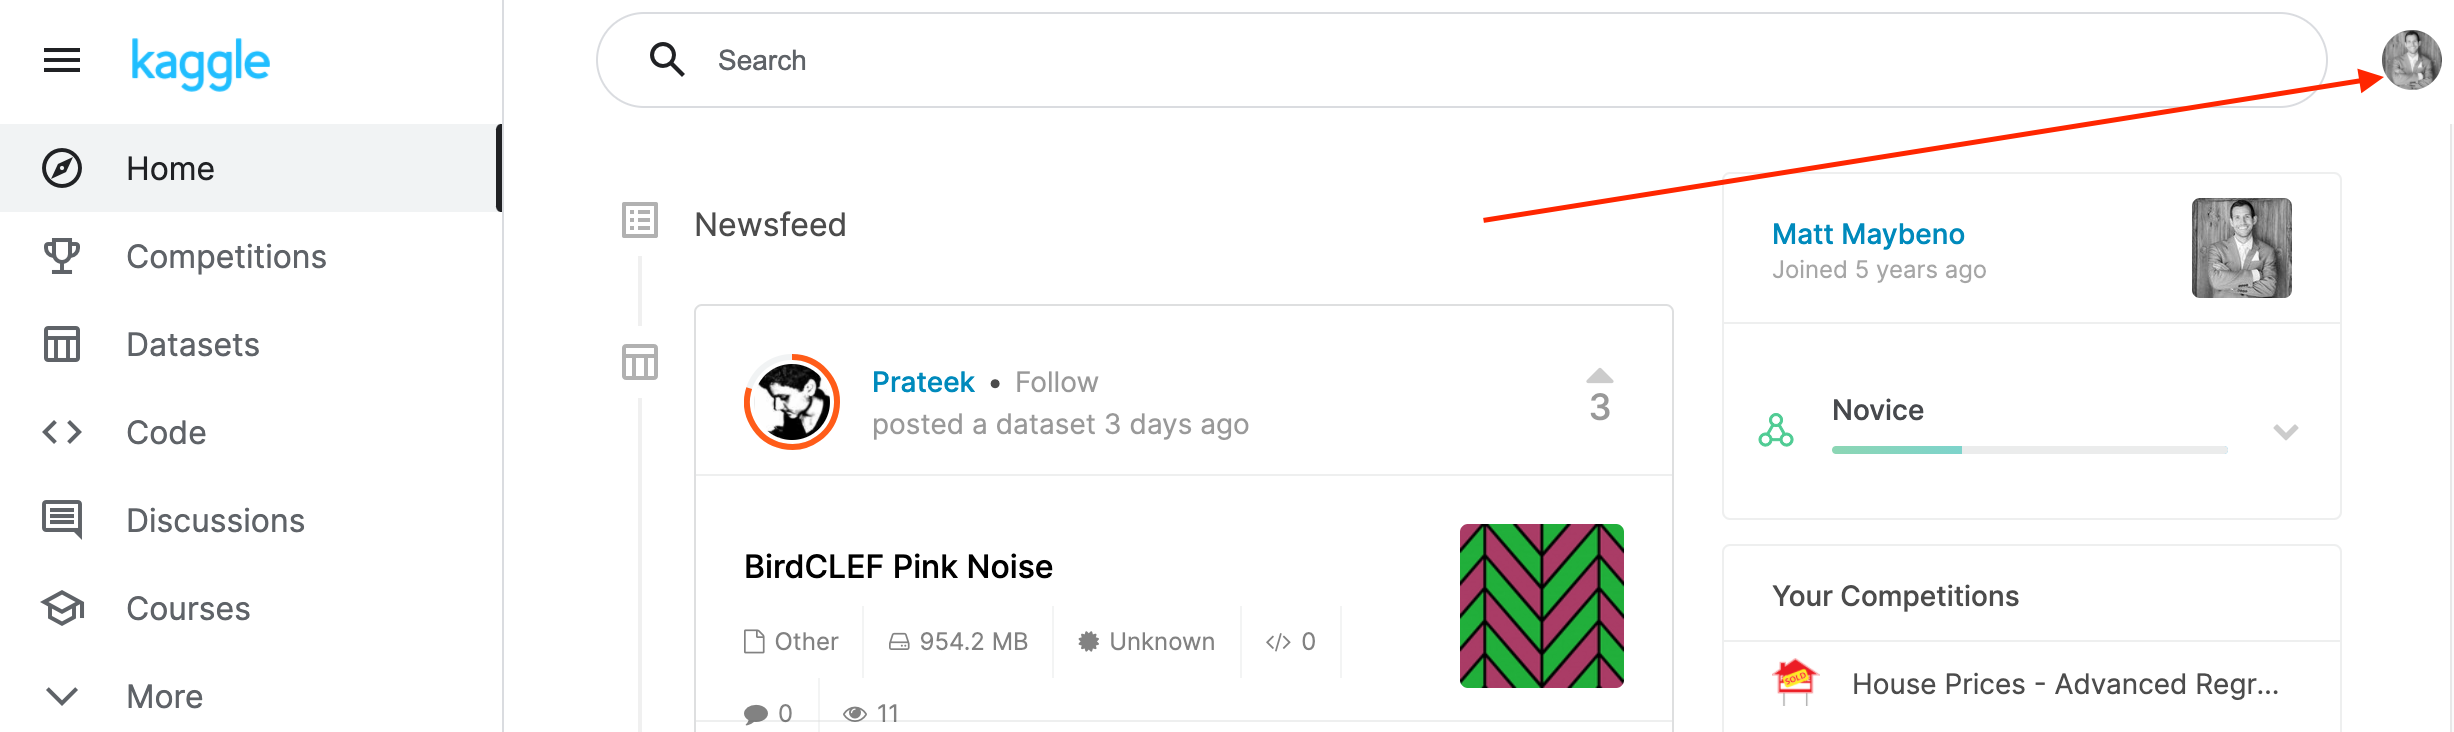
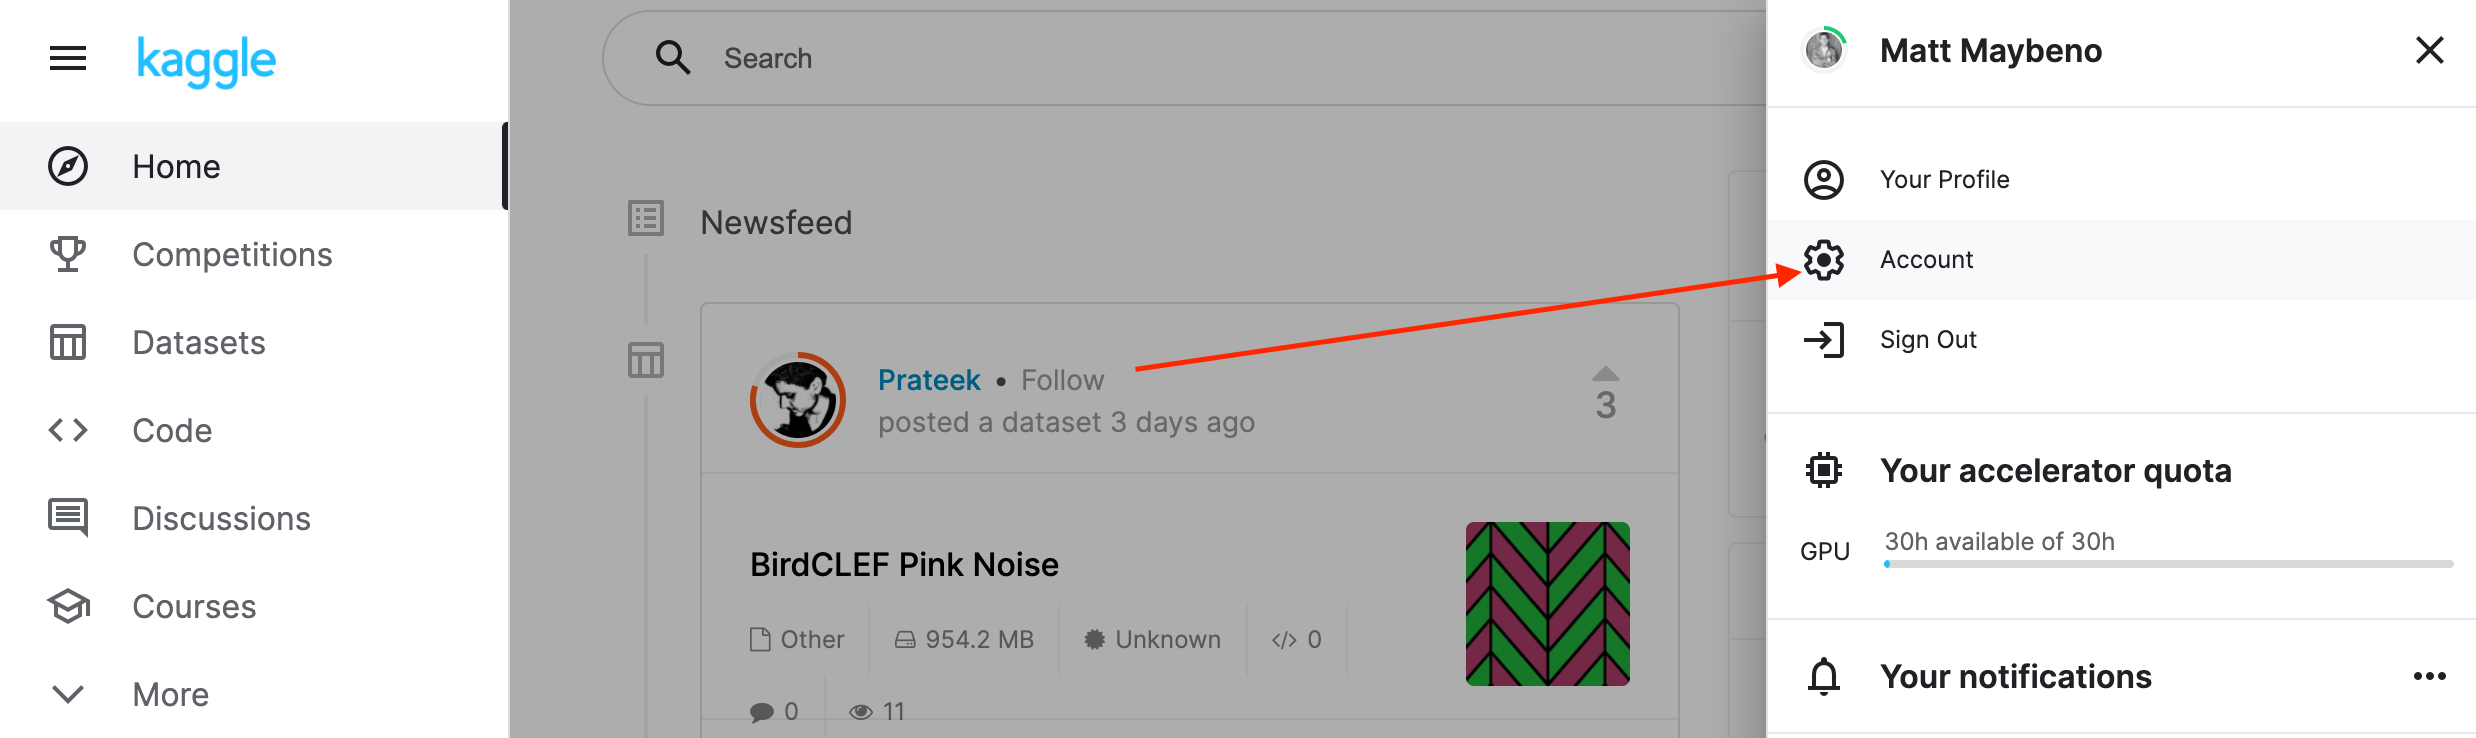
2. Scroll down to API and click Create New API Token.
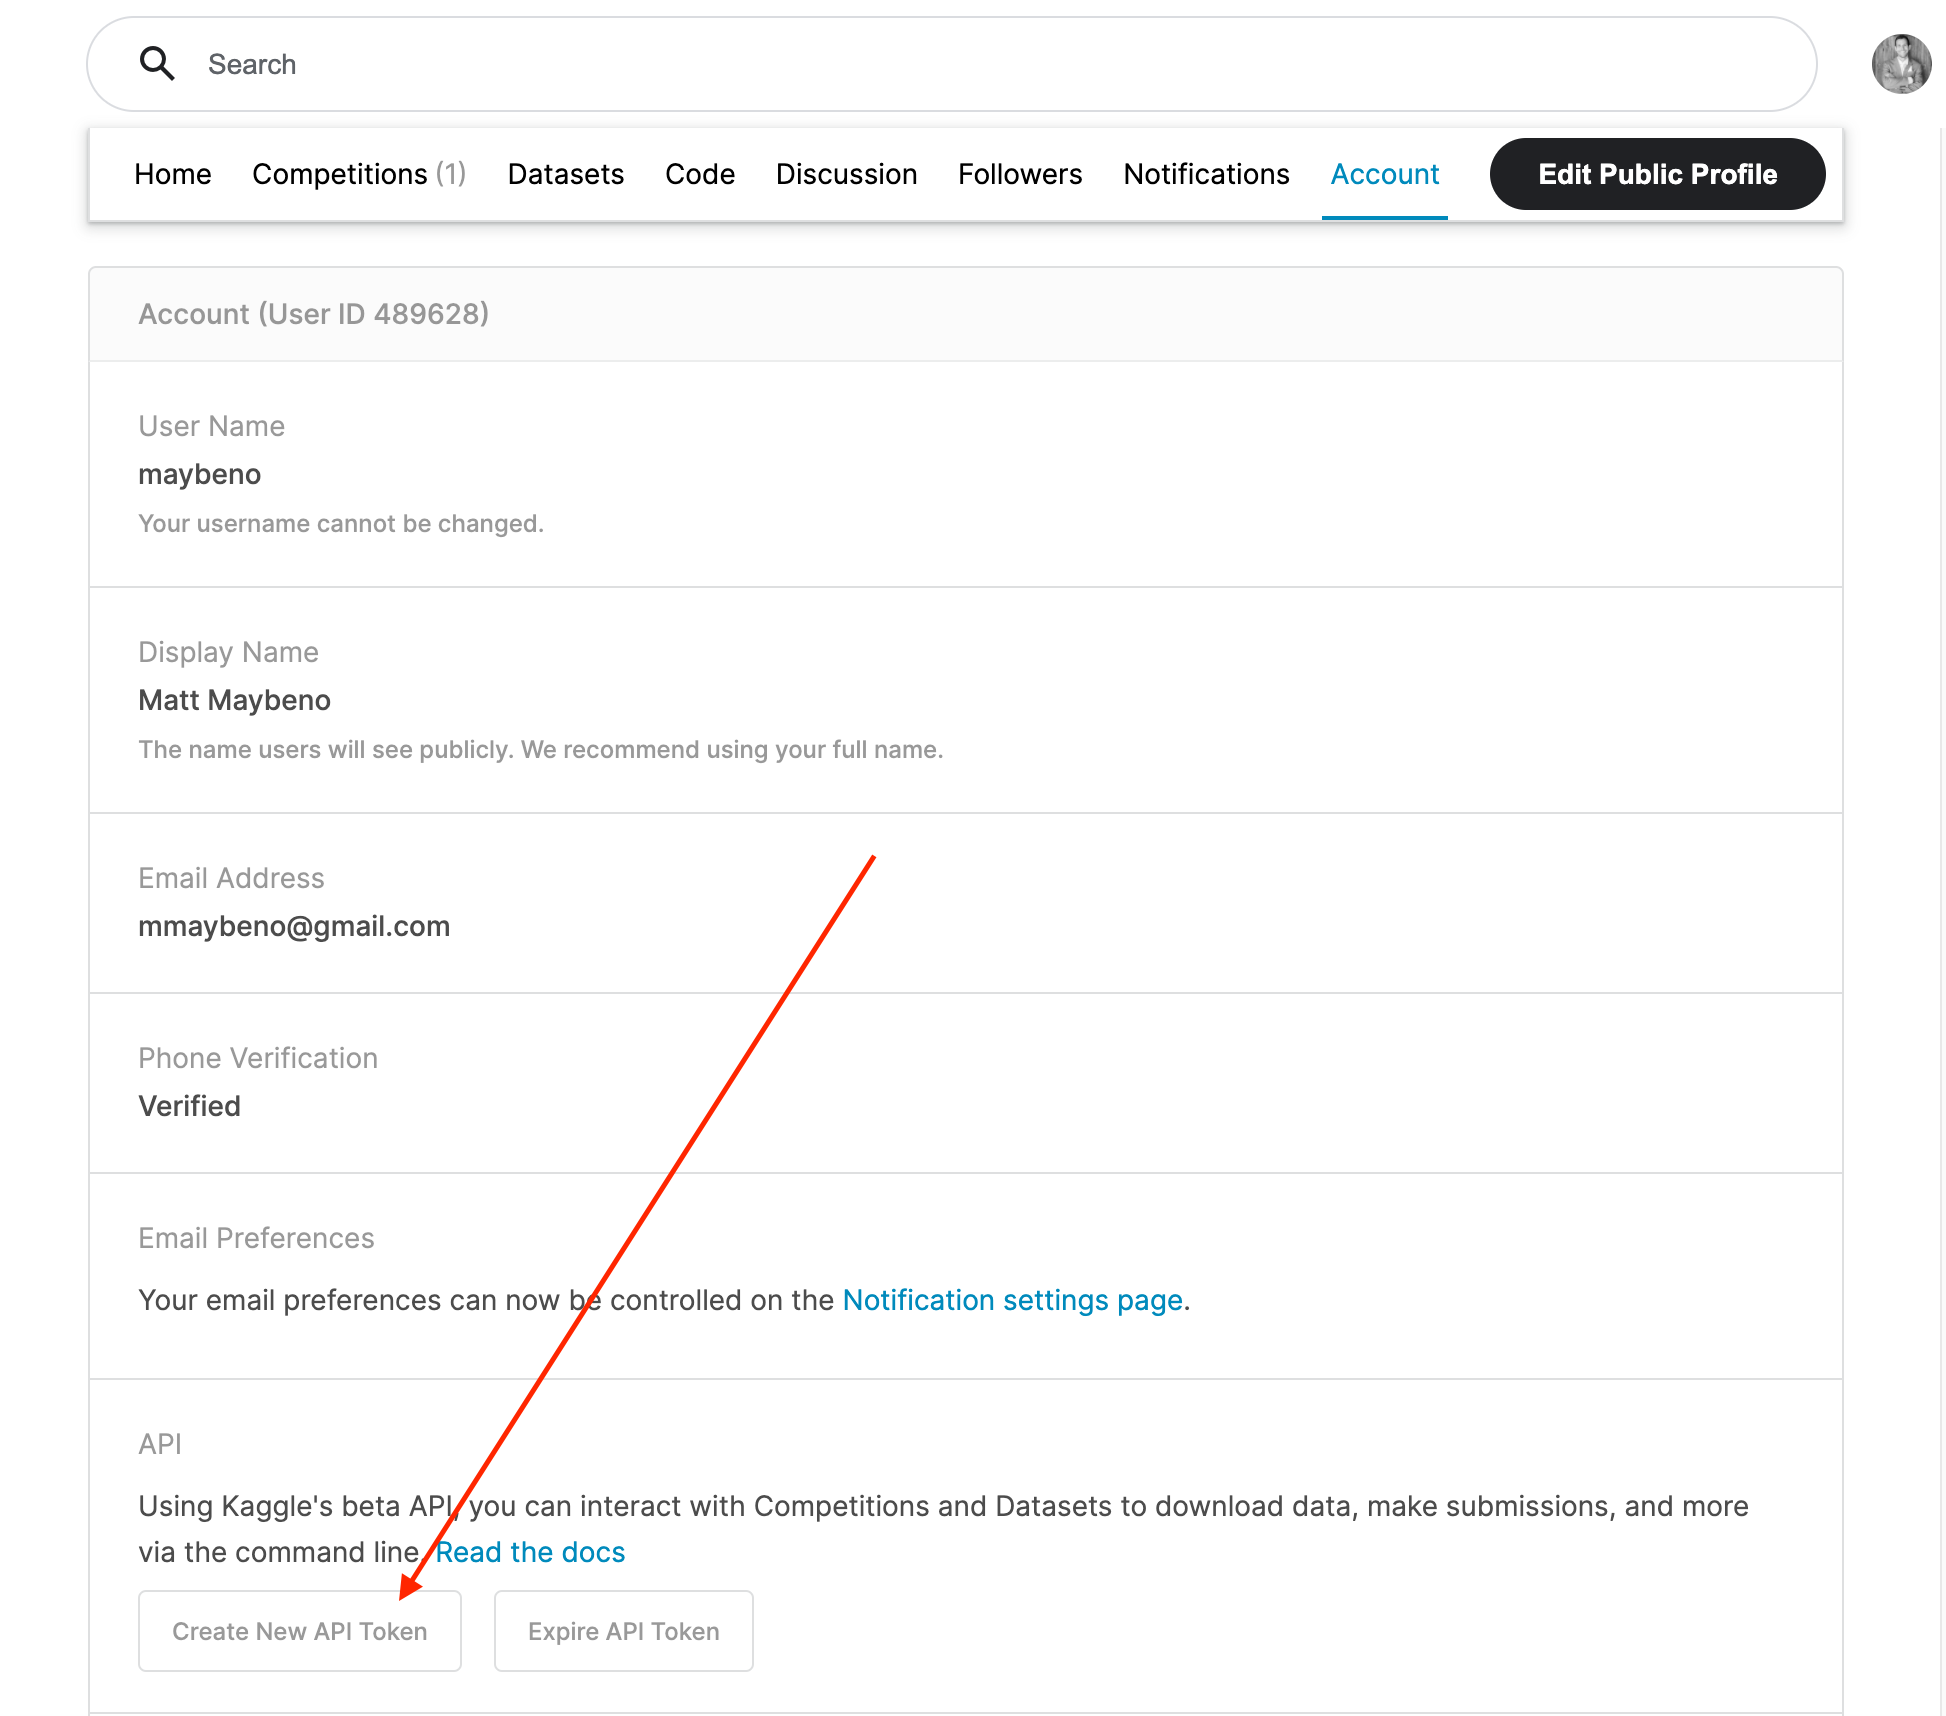
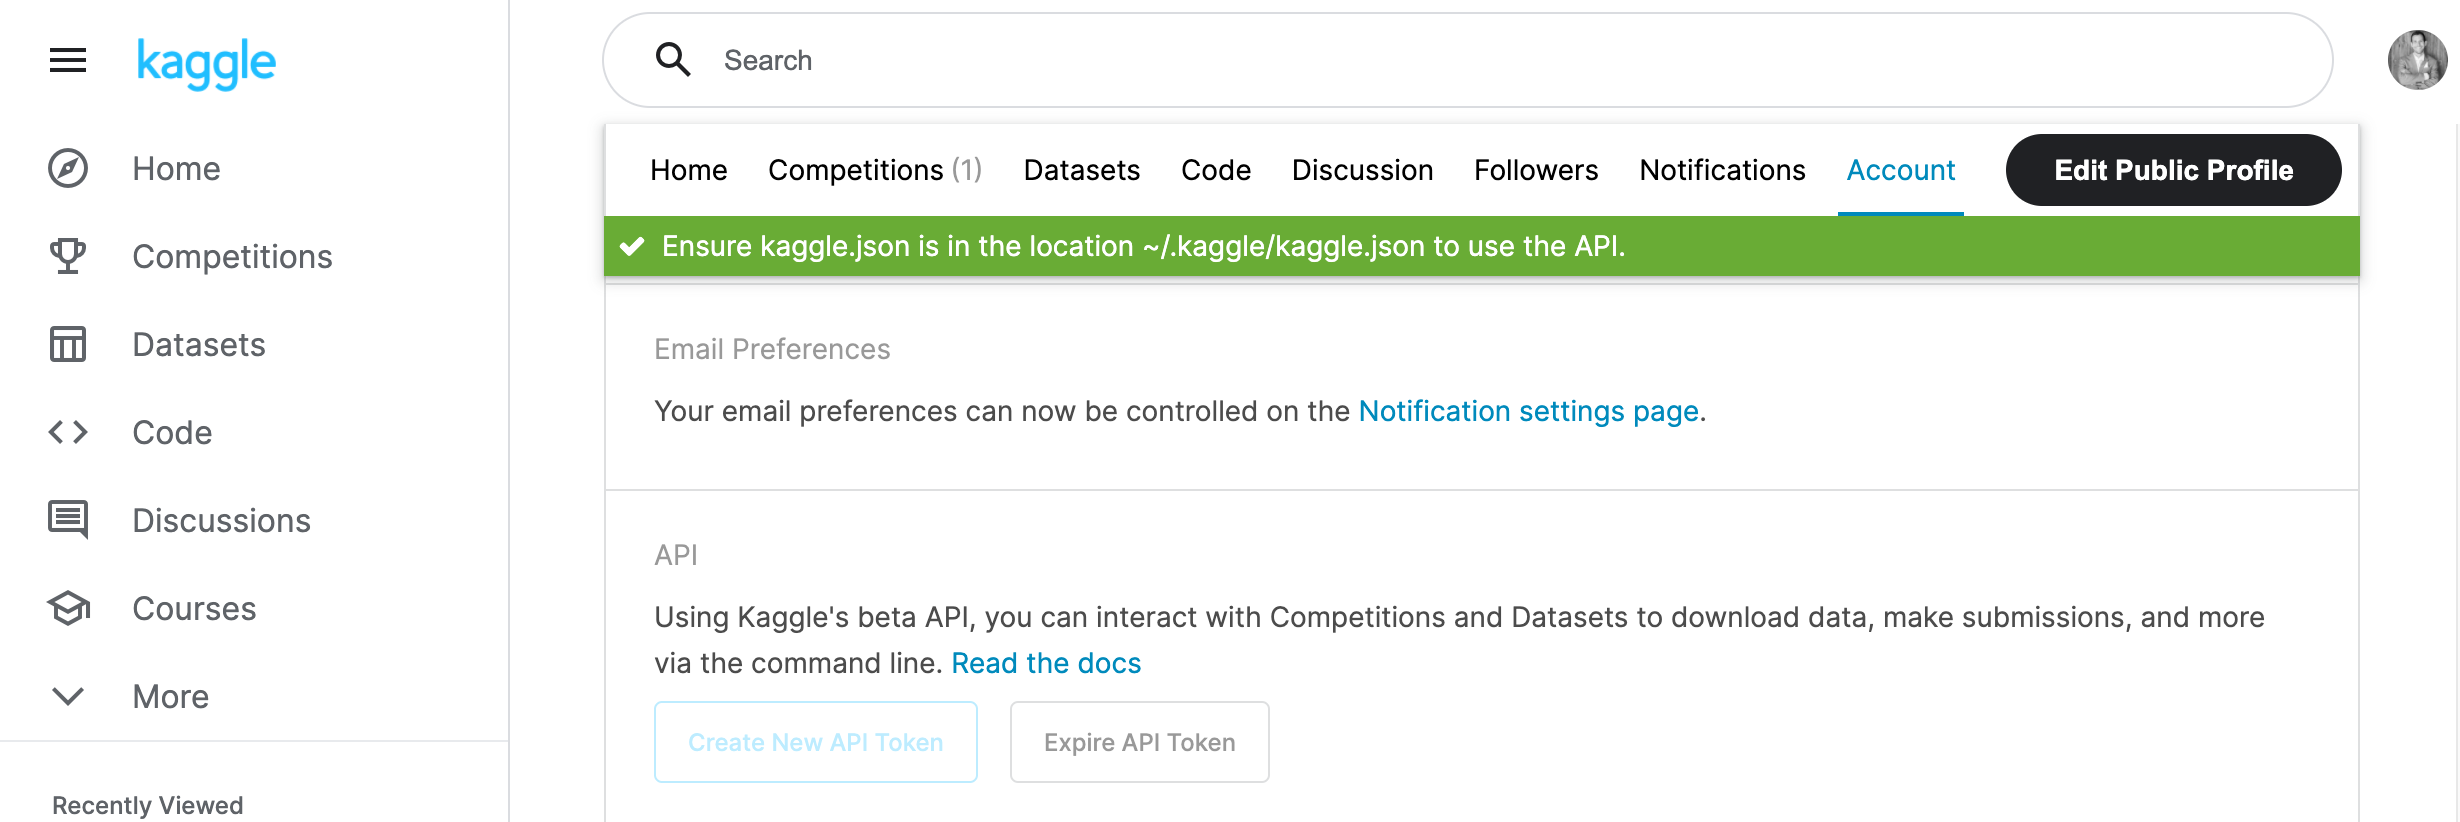
3. Open up `kaggle.json` and use the username and key.
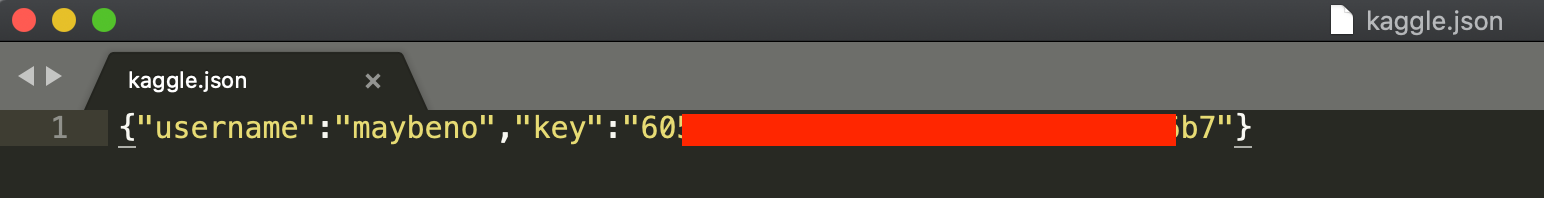

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [2]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

  Using cached pip-23.1.2-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 21.3.1
    Uninstalling pip-21.3.1:
      Successfully uninstalled pip-21.3.1
  Using cached setuptools-67.8.0-py3-none-any.whl (1.1 MB)
  Using cached wheel-0.40.0-py3-none-any.whl (64 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.3.0
    Uninstalling setuptools-59.3.0:
      Successfully uninstalled setuptools-59.3.0
  Using cached mxnet-1.9.1-py3-none-manylinux2014_x86_64.whl (49.1 MB)
  Using cached bokeh-2.0.1-py3-none-any.whl
  Attempting uninstall: bokeh
    Found existing installation: bokeh 2.4.2
    Uninstalling bokeh-2.4.2:
      Successfully uninstalled bokeh-2.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.5/226.5 kB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 163.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.5/292.5 kB 224.2 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [3]:
pip install autogluon

Note: you may need to restart the kernel to use updated packages.


### Import libraries

In [4]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()
%matplotlib inline

from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.inspection import permutation_importance

import warnings
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from autogluon.tabular import TabularPredictor

#evaluation metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error

# import tensorflow as tf
# from tensorflow import compat

warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setup Kaggle API Key

In [5]:
import pandas as pd
import time

In [6]:
pip install python-dotenv

  Using cached python_dotenv-0.21.1-py3-none-any.whl (19 kB)
Note: you may need to restart the kernel to use updated packages.


In [8]:
import os
from dotenv import load_dotenv

# Load the stored environment variables
load_dotenv()

# Get the values
username = os.getenv("KAGGLE_USERNAME")
key = os.getenv("KAGGLE_KEY")

In [9]:
!pip install --q kaggle 

In [10]:
!touch ~/.kaggle/kaggle.json
kaggle_api_token = {"username":username,"key":key}

In [11]:
import json 

# Writes API Credentials to Kaggle file
with open('/root/.kaggle/kaggle.json', 'w') as file: 
    json.dump(kaggle_api_token,file)

In [12]:
!chmod 600 ~/.kaggle/kaggle.json

### Download and explore dataset

### Go to the [bike sharing demand competition](https://www.kaggle.com/c/bike-sharing-demand) and agree to the terms

In [13]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand --force
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

  0%|                                                | 0.00/189k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 189k/189k [00:00<00:00, 4.75MB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [14]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv", parse_dates=["datetime"])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [15]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [16]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("test.csv", parse_dates=["datetime"])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [17]:
# Same thing as train and test dataset
submission = pd.read_csv("sampleSubmission.csv", parse_dates=["datetime"])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


***-: No missing values in the train and test dataset.***

## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are predicting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [18]:
predictor = TabularPredictor(
    label="count", problem_type="regression", eval_metric="root_mean_squared_error",
    learner_kwargs={"ignored_columns": ["casual", "registered"]}
).fit(
    train_data=train,
    time_limit=600,
    presets="best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20230527_202522/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230527_202522/"
AutoGluon Version:  0.6.2
Python Version:     3.7.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Apr 25 15:24:19 UTC 2023
Train Data Rows:    10886
Train Data Columns: 11
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2985.25 MB
	Train Data (Original)  Memory Usage: 0.78 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features

### Review AutoGluon's training run with ranking of models that did the best.

In [19]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -53.021261      16.198544  545.867090                0.000939           0.292421            3       True         14
1   RandomForestMSE_BAG_L2  -53.321414      12.819575  407.761495                0.611827          28.834338            2       True         12
2          LightGBM_BAG_L2  -55.058268      12.428097  403.253668                0.220349          24.326510            2       True         11
3          CatBoost_BAG_L2  -55.616513      12.253319  437.830495                0.045571          58.903338            2       True         13
4        LightGBMXT_BAG_L2  -60.242984      15.319858  433.510483                3.112110          54.583326            2       True         10
5    KNeighborsDist_BAG_L1  -84.125061       0.103867    0.031212         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -131.054161598899,
  'RandomForestMSE_BAG_L1': -116.54

In [20]:
# Leaderboard dataframe
leaderboard = pd.DataFrame(predictor.leaderboard(silent=True))
leaderboard

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-53.021261,16.198544,545.867090,0.000939,0.292421,3,True,14
1,RandomForestMSE_BAG_L2,-53.321414,12.819575,407.761495,0.611827,28.834338,2,True,12
2,LightGBM_BAG_L2,-55.058268,12.428097,403.253668,0.220349,24.326510,2,True,11
3,CatBoost_BAG_L2,-55.616513,12.253319,437.830495,0.045571,58.903338,2,True,13
4,LightGBMXT_BAG_L2,-60.242984,15.319858,433.510483,3.112110,54.583326,2,True,10
5,KNeighborsDist_BAG_L1,-84.125061,0.103867,0.031212,0.103867,0.031212,1,True,2
6,WeightedEnsemble_L2,-84.125061,0.105128,0.589463,0.001261,0.558251,2,True,9
7,KNeighborsUnif_BAG_L1,-101.546199,0.103987,0.033922,0.103987,0.033922,1,True,1
8,RandomForestMSE_BAG_L1,-116.544294,0.535664,10.850922,0.535664,10.850922,1,True,5
9,ExtraTreesMSE_BAG_L1,-124.588053,0.562526,5.731348,0.562526,5.731348,1,True,7


<AxesSubplot:xlabel='model'>

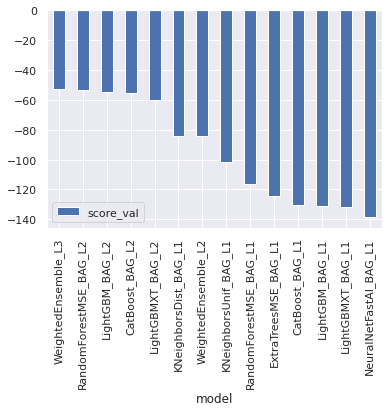

In [21]:
predictor.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

### Create predictions from test dataset

In [22]:
predictions = predictor.predict(test)
predictions.head()

0    23.363766
1    41.955719
2    45.371128
3    49.706100
4    51.845631
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [23]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.849510
std        89.902069
min         3.240443
25%        20.142696
50%        64.363220
75%       167.251678
max       364.819427
Name: count, dtype: float64

In [24]:
# How many negative values do we have?
predictions.lt(0).value_counts()

False    6493
Name: count, dtype: int64

In [25]:
# Set them to zero
predictions.iloc[predictions<0] = 0
predictions.lt(0).value_counts()

False    6493
Name: count, dtype: int64

### Set predictions to submission dataframe, save, and submit

In [26]:
submission["count"] = pd.DataFrame(predictions)
submission.to_csv("submission.csv", index=False)

In [27]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 448kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [28]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                        date                 description                          status    publicScore  privateScore  
------------------------------  -------------------  -----------------------------------  --------  -----------  ------------  
submission.csv                  2023-05-27 20:36:07  first raw submission                 pending                              
submission_hpo3.csv             2023-05-27 19:54:29                                       complete  0.51851      0.51851       
submission_hpo3.csv             2023-05-27 19:53:15  new features with hyperparameters-3  complete  0.51851      0.51851       
submission_hpo3.csv             2023-05-27 19:52:09  new features with hyperparameters-3  error                                
tail: write error: Broken pipe


#### Initial score of `1.79272`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

### *A short description of the Features*  
`datetime` - hourly date + timestamp  
`season` - 1 = spring, 2 = summer, 3 = fall, 4 = winter  
`holiday` - whether the day is a holiday/not  
`workingday` - whether the day is neither a weekend nor holiday  
`weather` - 
* 1: Clear, Few clouds, Partly cloudy, Partly cloudy
* 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
* 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
* 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog  

`temp` - temperature in Celsius  
`atemp` - "feels like" temperature in Celsius  
`humidity` - relative humidity  
`windspeed` - wind speed  
`casual` - number of non-registered user rentals initiated  
`registered` - number of registered user rentals initiated  
`count` - number of total rentals

### Checking for Missing Values

In [29]:
# Checking any null values in train data
train.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [30]:
# Checking any null values in test data
test.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

***-: No missing values in the train and test dataset.***

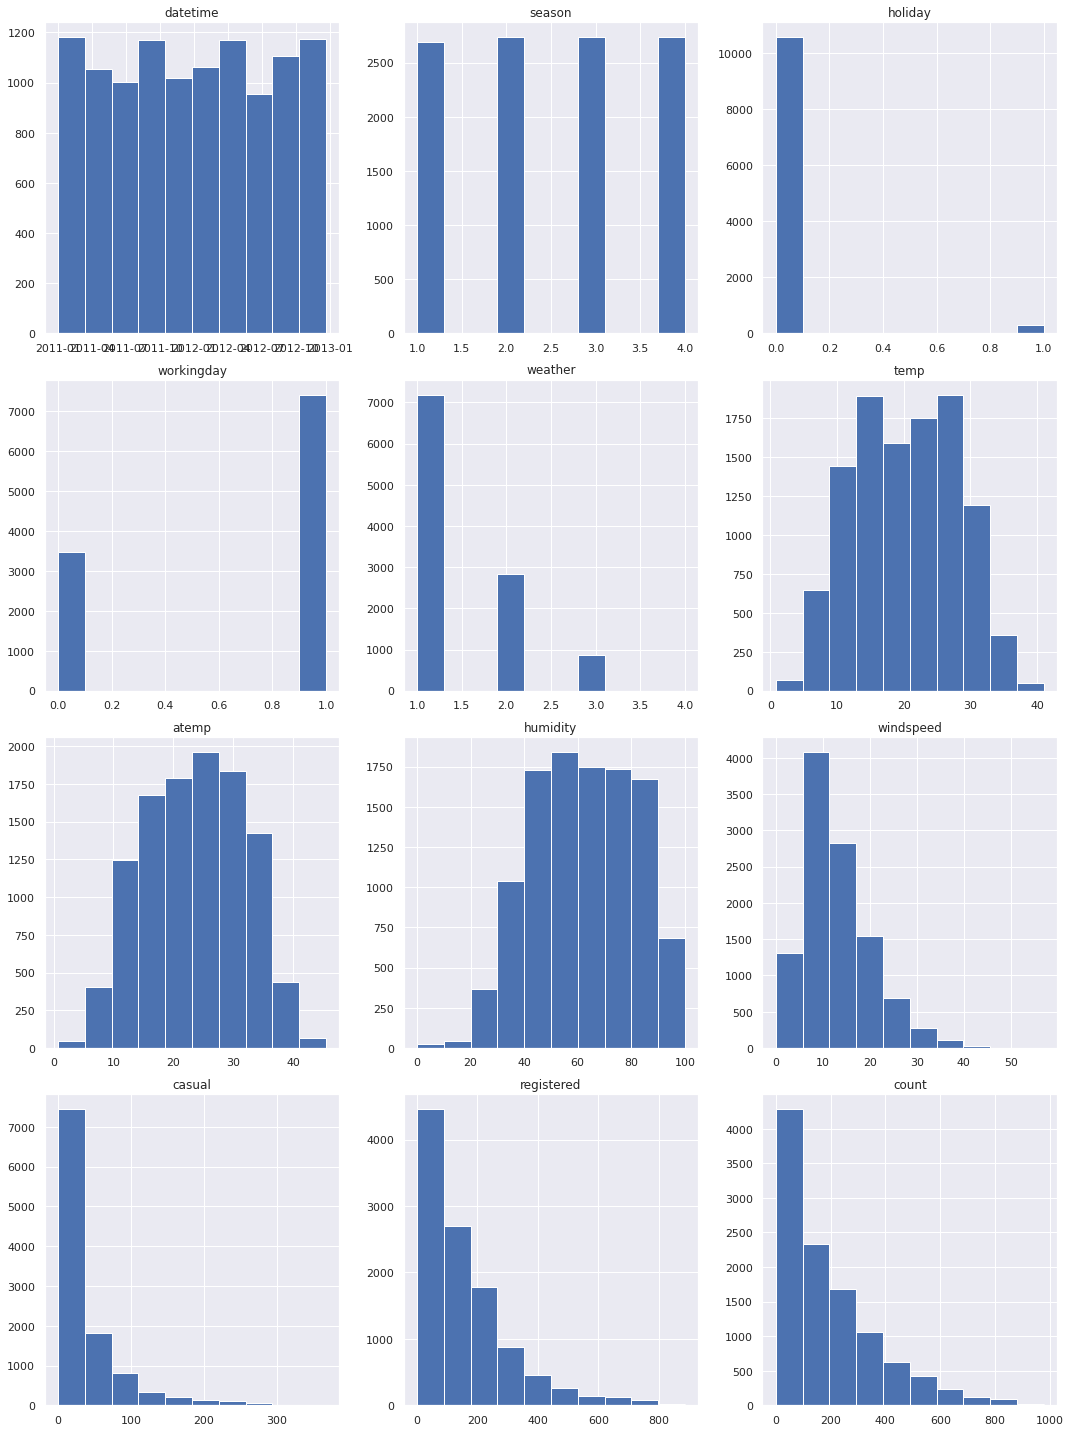

In [31]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(15,20))
plt.tight_layout()
plt.show()

***1. `season` and `weather` features are likely to be categorical features from the plot  
2. `holiday` and `workingday` features are one-hot encoded columns with 0 and 1  
3. `temp`, `atemp` and `humidity` features depicts normal distribution***

In [32]:
# For creating new feature, checking the data-types of all columns
train.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object

In [33]:
test.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
dtype: object

In [34]:
# Shape of train and test datasets
print("Train Dataset Shape : ", train.shape)
print("Test Dataset Shape  : ", test.shape)

Train Dataset Shape :  (10886, 12)
Test Dataset Shape  :  (6493, 9)


***-: Some features are missing in the test dataset.***

### Plot Heatmap using Correlation Matrix

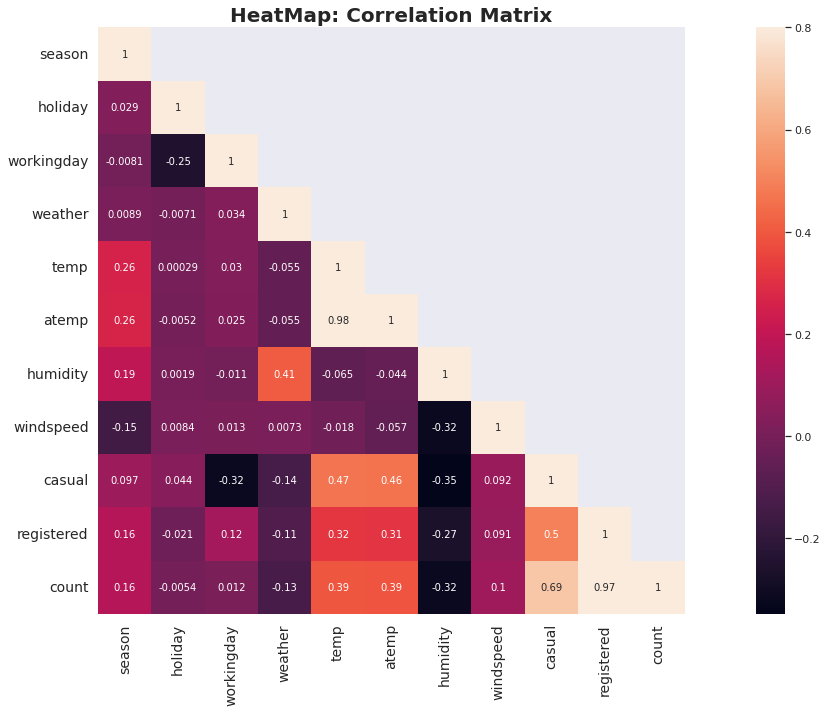

In [35]:
corrMatt = train[['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True, annot=True)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14, rotation=0)
plt.title("HeatMap: Correlation Matrix", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.autoscale()
plt.show()

***1. `temp` and `atemp` features are highly correlated with a positive correlation of 0.97  
2. `casual` and `registered` are also highly correlated to the target- `count`  
3. `holiday` and `workingday` show the least correlation with `count` feature  
4. `weather` and `humidity` is slightly negatively correlated   
5. `humidity` is inversely related to count as expected as the weather is humid people will not like to travel on a bike.  
6. Also note that `weather` and `count` are highly inversely related. This is bcoz for uour data as weather increases from (1 to 4) implies that weather is getting more worse and so lesser people will rent bikes.  
7. registered/casual and count are highly related which indicates that most of the bikes that are rented are registered.***  

### Creating New Features

In [36]:
x_date = test['datetime'].values

In [37]:
# Checking 'datetime' feature in train data
train['datetime'].head()

0   2011-01-01 00:00:00
1   2011-01-01 01:00:00
2   2011-01-01 02:00:00
3   2011-01-01 03:00:00
4   2011-01-01 04:00:00
Name: datetime, dtype: datetime64[ns]

***Variation is seen on hourly basis. So splitting the `datetime` feature into year, month, day (dayofweek) and hour respectively.***

In [38]:
# create a new feature: changing the data-type of 'datetime' column

train['datetime']= pd.to_datetime(train['datetime'])
test['datetime']= pd.to_datetime(test['datetime'])

In [39]:
# Splitting the 'datetime' feature in train data
train["hour"] = [t.hour for t in pd.DatetimeIndex(train.datetime)]
train["day"] = [t.dayofweek for t in pd.DatetimeIndex(train.datetime)]
train["month"] = [t.month for t in pd.DatetimeIndex(train.datetime)]
train['year'] = [t.year for t in pd.DatetimeIndex(train.datetime)]
train['year'] = train['year'].map({2011:0, 2012:1})
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,month,year
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,5,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,5,1,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,5,1,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,5,1,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,5,1,0


In [40]:
# Splitting the 'datetime' feature in test data
test["hour"] = [t.hour for t in pd.DatetimeIndex(test.datetime)]
test["day"] = [t.dayofweek for t in pd.DatetimeIndex(test.datetime)]
test["month"] = [t.month for t in pd.DatetimeIndex(test.datetime)]
test['year'] = [t.year for t in pd.DatetimeIndex(test.datetime)]
test['year'] = test['year'].map({2011:0, 2012:1})
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,month,year
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,0,3,1,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,3,1,0
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2,3,1,0
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,3,1,0
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,4,3,1,0


In [41]:
# now can drop datetime column.
train.drop('datetime',axis=1,inplace=True)
test.drop('datetime',axis=1,inplace=True)

In [42]:
# Recheck datatype of features in the train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
 11  hour        10886 non-null  int64  
 12  day         10886 non-null  int64  
 13  month       10886 non-null  int64  
 14  year        10886 non-null  int64  
dtypes: float64(3), int64(12)
memory usage: 1.2 MB


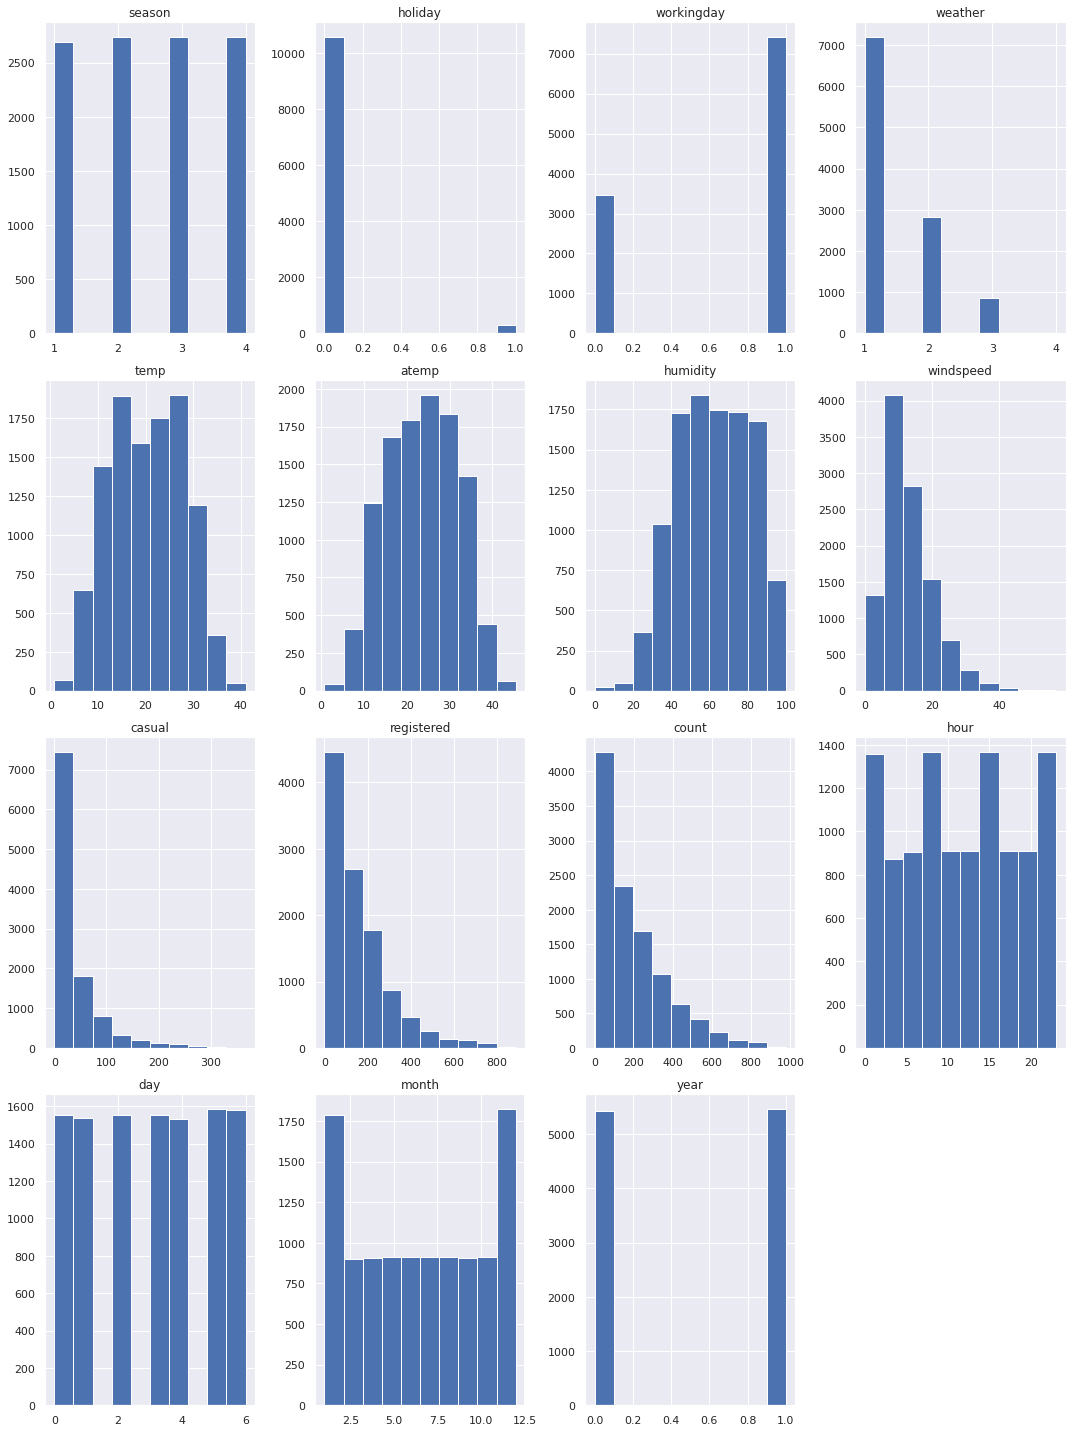

In [43]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(15,20))
plt.tight_layout()
plt.show()

### Outliers Analysis

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

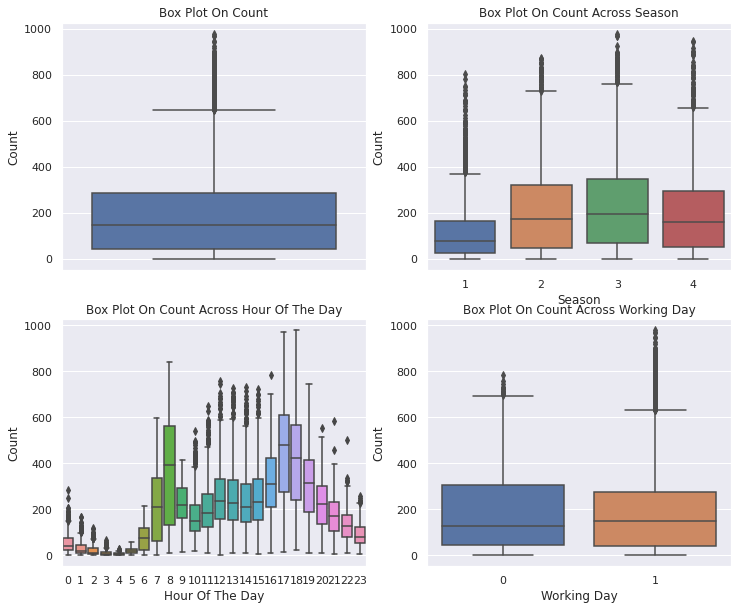

In [44]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=train,y="count",orient="v",ax=axes[0][0])
sn.boxplot(data=train,y="count",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=train,y="count",x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=train,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

***1. At first look, "count" variable contains lot of outlier data points which skews the distribution towards right (as there are more data points beyond Outer Quartile Limit).  
2. Season-1 has got relatively lower count.The dip in median value in boxplot gives evidence for it.  
3. The boxplot with "Hour Of The Day" is quiet interesting.The median value are relatively higher at 7AM - 8AM and 5PM - 6PM. It can be attributed to regular school and office users at that time.  
4. Most of the outlier points are mainly contributed from "Working Day" than "Non Working Day".***

In [45]:
def delete_outliers(data, df):
    original_shape = df.shape
    mean = np.mean(data)
    std = np.std(data)
    outliers=np.abs(data-mean) > (3*std)
    outliers_num = len(train[outliers])
    df.drop(index=data[outliers].index, inplace=True)
    print("Have already deleted",outliers_num,"outliers")
    print ("Shape Before Delete Ouliers: ",original_shape)
    print ("Shape After Delete Ouliers: ",df.shape)

In [46]:
delete_outliers(train['count'], train)

Have already deleted 147 outliers
Shape Before Delete Ouliers:  (10886, 15)
Shape After Delete Ouliers:  (10739, 15)


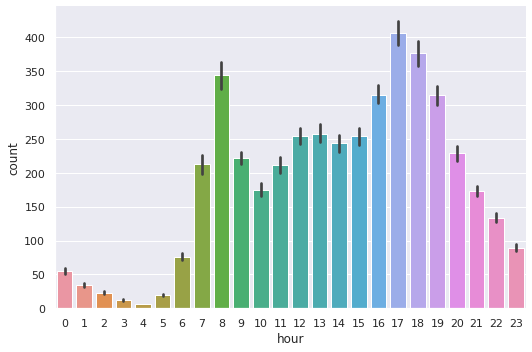

In [47]:
# Variation in`count` w.r.t `hour`

# Using catplot: 'kind':bar makes sure to take value of 'count' for every record into account
sn.catplot(x="hour",y="count",data=train,kind='bar',height=5,aspect=1.5) 
plt.tight_layout()
plt.show()

***Frequency of Bike Rides (Hourly-basis):***
* `High`: From 7-9 (7am - 9am) and 16-19 (4pm - 7pm)  
* `Moderate`: 10-15 (10am - 3pm)
* `Low`: Low: 0-6 (12am - 6am) and 20-24 (8pm - 12am)  
  
  ***This makes sense as most people who rent these bikes could potentially be young college students or working professionals, who actively commute via some means of transport during peak hours of the day mentioned under the `High` category.***

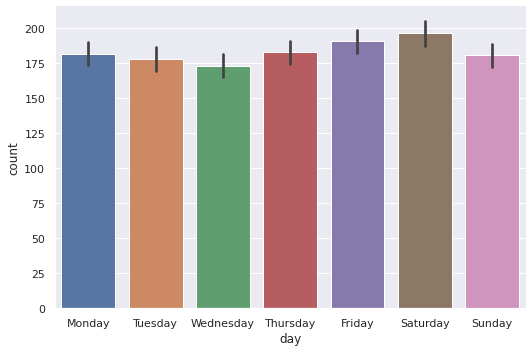

In [48]:
# Variation in`count` w.r.t `day` (dayofweek) [0: Monday -> 6: Sunday]

# Using catplot: 'kind':bar makes sure to take value of 'count' for every record into account
sn.catplot(x="day",y="count",data=train,kind='bar',height=5,aspect=1.5) 
plt.tight_layout()
plt.xticks(ticks=range(0,7), labels=["Monday", "Tuesday", "Wednesday", 
                                     "Thursday", "Friday", "Saturday", "Sunday"])
plt.show()

***Not much variation or pattern is seen in the bike rental counts with respect to featureday.***

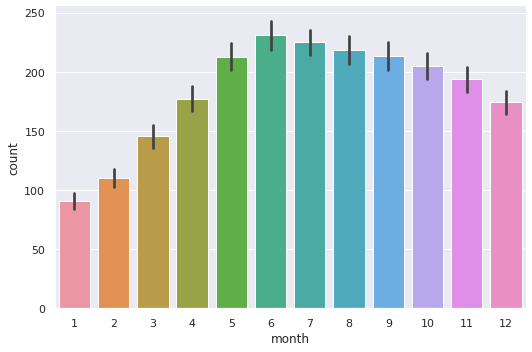

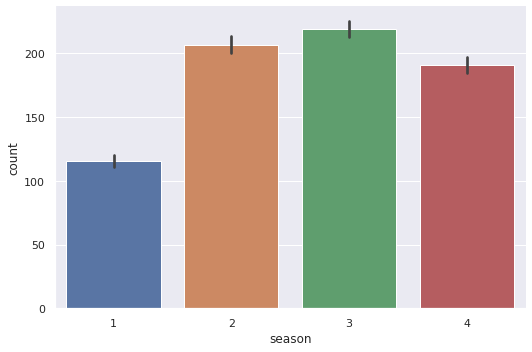

In [49]:
# Variation in`count` w.r.t `month` and 'season'

# Using catplot: 'kind':bar makes sure to take value of 'count' for every record into account
sn.catplot(x="month",y="count",data=train,kind='bar',height=5,aspect=1.5) 
sn.catplot(x="season",y="count",data=train,kind='bar',height=5,aspect=1.5)
plt.tight_layout()
plt.show()

***Since seasons show variation in the number of bike rentals count, it is obvious to notice the same from the month feature, but at a slightly more granular level.***

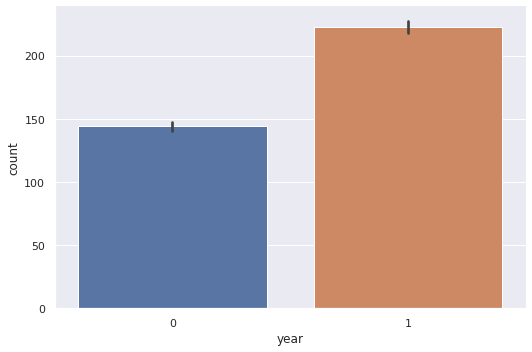

In [50]:
# Variation in`count` w.r.t `year`

# Using catplot: 'kind':bar makes sure to take value of 'count' for every record into account
sn.catplot(x="year",y="count",data=train,kind='bar',height=5,aspect=1.5)
plt.tight_layout()
plt.show()

***Year 2012 has higher bike demand as compared to 2011.***

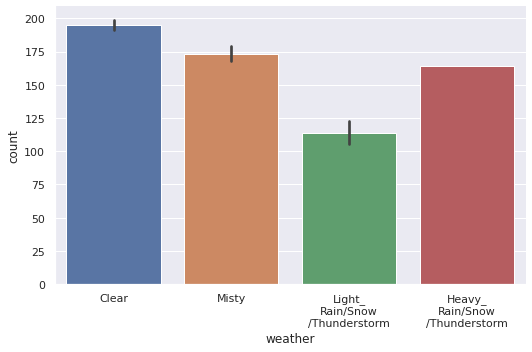

In [51]:
# Variation in`count` w.r.t `weather'

# Using catplot: 'kind':bar makes sure to take value of 'count' for every record into account
sn.catplot(x="weather",y="count",data=train,kind='bar',height=5,aspect=1.5) 
plt.xticks(ticks=range(0,4), labels=["Clear","Misty", 
                                     "Light_\nRain/Snow\n/Thunderstorm", 
                                     "Heavy_\nRain/Snow\n/Thunderstorm"])
plt.tight_layout()
plt.show()

***Bike rental counts are highest in Clear weather, followed by Misty weather.***

### Graph plot of number of users count w.r.t hours on the basis of `season`, `day` and `registered`/`casual`

Text(0, 0.5, 'Count')

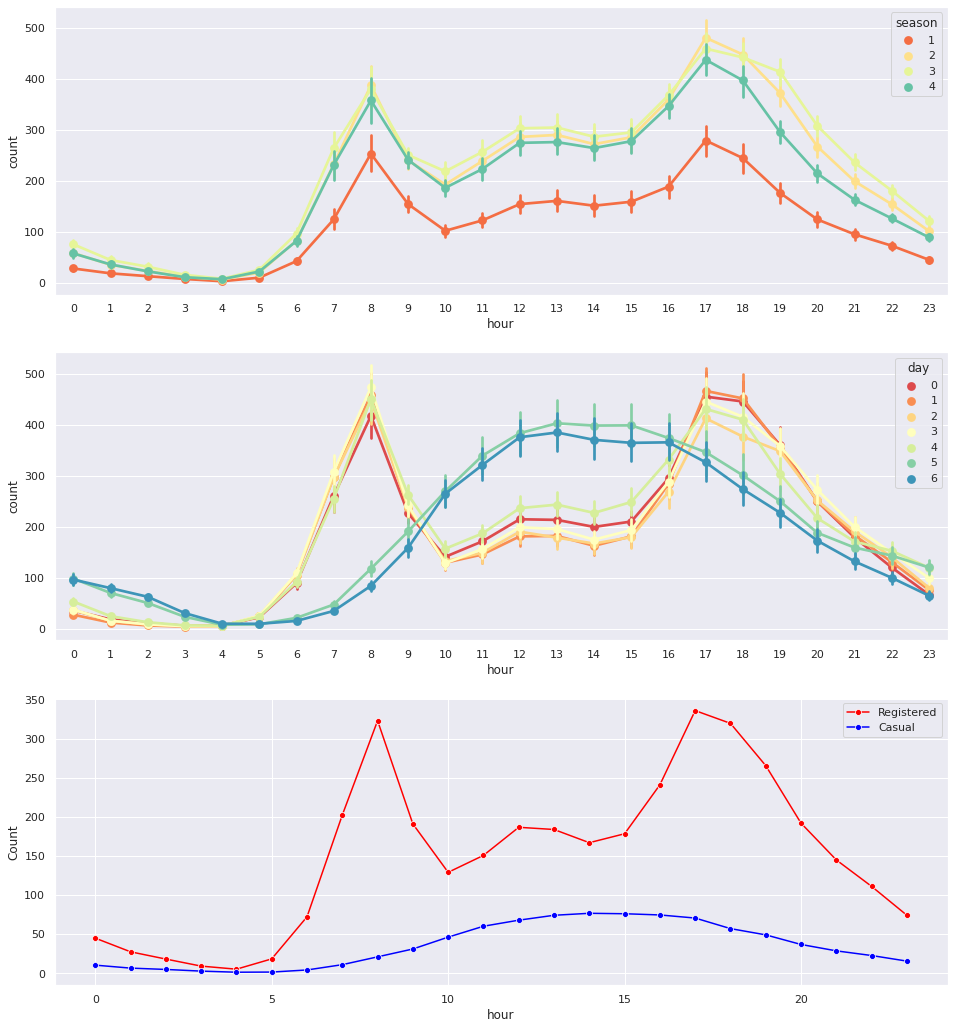

In [52]:
fig,(ax1,ax2,ax3)= plt.subplots(nrows=3)
fig.set_size_inches(16,18)
sn.pointplot(x='hour',y='count',hue='season',join=True, data=train, palette="Spectral", ax=ax1)
sn.pointplot(x='hour',y='count',hue='day',join=True, data=train, palette="Spectral", ax=ax2)
sn.lineplot(x='hour', y='registered', data=train, color='red',label='Registered', marker='o', ax=ax3, ci=None)
sn.lineplot(x='hour', y='casual', data=train, color='blue', label='Casual', marker='o', ax=ax3, ci=None)
ax3.set_ylabel('Count')

* It is observed that many people, regardless of their registration status, tend to rent bicycles between 10AM and 4PM. This trend is likely due to the fact that people are more likely to use bicycles for leisure activities during this time of the day.

* Furthermore, it is also found that most un-registered users tend to rent bicycles around 10am-3pm on weekends. This could be because casual users may use other forms of transportation to go to work/school during the weekdays and only rent bicycles during weekends for recreational activities.

* On weekdays, the peak rental count around 7AM-8AM and 5PM-6PM is primarily contributed by registered users. As previously mentioned, this can be attributed to regular school and office commuters who rely on bicycles as their primary mode of transportation during these times.

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [53]:
train["season"] = train["season"].astype('category')
train["weather"] = train["weather"].astype('category')
test["season"] = test["season"].astype('category')
test["weather"] = test["weather"].astype('category')

In [54]:
# View are new feature
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,month,year
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,5,1,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,5,1,0
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,5,1,0
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,5,1,0
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,5,1,0


<AxesSubplot:xlabel='month', ylabel='Count'>

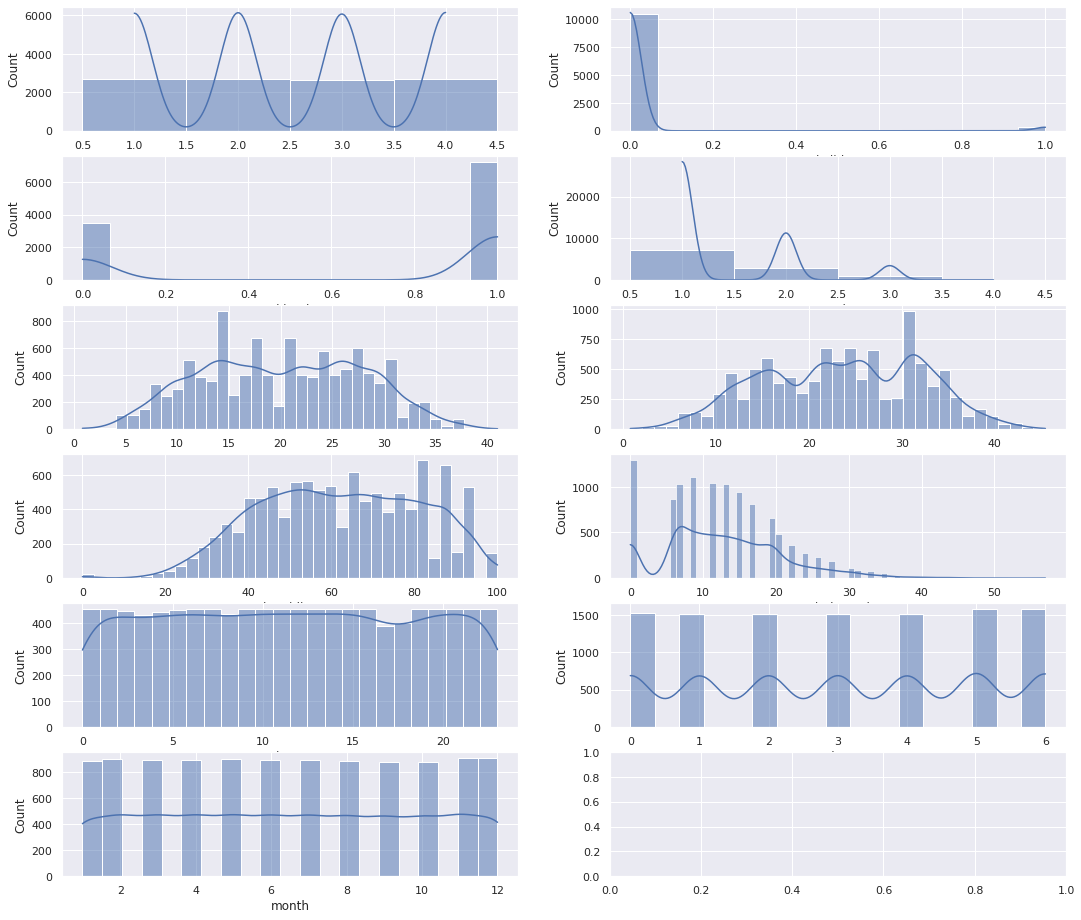

In [55]:
# View histogram of all features again now with the hour feature
fig, axes = plt.subplots(nrows=6,ncols=2)
fig.set_size_inches(18, 16)
sn.histplot(data=train, x="season", kde=True, ax=axes[0][0])
sn.histplot(data=train, x="holiday", kde=True, ax=axes[0][1])
sn.histplot(data=train, x="workingday", kde=True, ax=axes[1][0])
sn.histplot(data=train, x="weather", kde=True, ax=axes[1][1])
sn.histplot(data=train, x="temp", kde=True, ax=axes[2][0])
sn.histplot(data=train, x="atemp", kde=True, ax=axes[2][1])
sn.histplot(data=train, x="humidity", kde=True, ax=axes[3][0])
sn.histplot(data=train, x="windspeed", kde=True, ax=axes[3][1])
sn.histplot(data=train, x="hour", kde=True, ax=axes[4][0])
sn.histplot(data=train, x="day", kde=True, ax=axes[4][1])
sn.histplot(data=train, x="month", kde=True, ax=axes[5][0])

## Step 5: Rerun the model with the same settings as before, just with more features

In [56]:
predictor_new_features = TabularPredictor(
    label="count", problem_type="regression", eval_metric="root_mean_squared_error",
    learner_kwargs={"ignored_columns": ["casual", "registered"]}
).fit(
    train_data=train,
    time_limit=600,
    presets="best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20230527_203636/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230527_203636/"
AutoGluon Version:  0.6.2
Python Version:     3.7.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Apr 25 15:24:19 UTC 2023
Train Data Rows:    10739
Train Data Columns: 14
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2058.26 MB
	Train Data (Original)  Memory Usage: 0.88 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features

In [57]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -32.682233      24.316767  551.764457                0.001906           0.847538            3       True         16
1      WeightedEnsemble_L2  -32.952357      20.460502  349.444635                0.000906           0.517039            2       True          9
2     ExtraTreesMSE_BAG_L2  -32.961359      22.517568  406.250948                0.600627           7.877751            2       True         14
3          CatBoost_BAG_L2  -33.012860      22.011702  457.546719                0.094761          59.173522            2       True         13
4          LightGBM_BAG_L2  -33.179283      22.061668  420.410890                0.144727          22.037694            2       True         11
5   RandomForestMSE_BAG_L2  -33.215227      22.957948  425.505589         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -106.24742596432883,
  'KNeighborsDist_BAG_L1': -102.8690257292403

In [58]:
predictions_new_features = predictor_new_features.predict(test)
predictions_new_features.head()

0    11.884833
1     5.565832
2     4.112204
3     3.380260
4     3.381506
Name: count, dtype: float32

In [59]:
predictions_new_features.describe()

count    6493.000000
mean      187.873230
std       168.502533
min         2.179970
25%        44.675636
50%       146.491241
75%       282.545471
max       696.987000
Name: count, dtype: float64

In [60]:
# Leaderboard dataframe
leaderboard_new_feat = pd.DataFrame(predictor_new_features.leaderboard(silent=True))
leaderboard_new_feat

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-32.682233,24.316767,551.764457,0.001906,0.847538,3,True,16
1,WeightedEnsemble_L2,-32.952357,20.460502,349.444635,0.000906,0.517039,2,True,9
2,ExtraTreesMSE_BAG_L2,-32.961359,22.517568,406.250948,0.600627,7.877751,2,True,14
3,CatBoost_BAG_L2,-33.012860,22.011702,457.546719,0.094761,59.173522,2,True,13
4,LightGBM_BAG_L2,-33.179283,22.061668,420.410890,0.144727,22.037694,2,True,11
5,RandomForestMSE_BAG_L2,-33.215227,22.957948,425.505589,1.041008,27.132393,2,True,12
6,LightGBMXT_BAG_L2,-33.482522,22.223230,422.328394,0.306289,23.955197,2,True,10
7,LightGBM_BAG_L1,-34.423329,2.338745,35.975683,2.338745,35.975683,1,True,4
8,CatBoost_BAG_L1,-34.554943,0.258031,217.196623,0.258031,217.196623,1,True,6
9,NeuralNetFastAI_BAG_L2,-35.110564,22.433739,434.695559,0.516798,36.322362,2,True,15


<AxesSubplot:xlabel='model'>

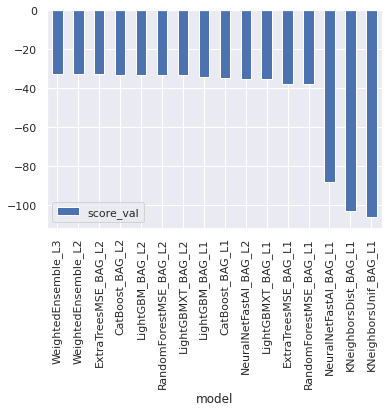

In [61]:
predictor_new_features.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

In [62]:
# Remember to set all negative values to zero
predictions_new_features.lt(0).value_counts()

False    6493
Name: count, dtype: int64

In [63]:
# Set them to zero
predictions_new_features.iloc[predictions<0] = 0
predictions_new_features.lt(0).value_counts()

False    6493
Name: count, dtype: int64

In [64]:
# Same submitting predictions
submission_new_features = pd.read_csv('./sampleSubmission.csv', parse_dates=["datetime"])
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [65]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 310kB/s]
Successfully submitted to Bike Sharing Demand

In [66]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                        date                 description                          status    publicScore  privateScore  
------------------------------  -------------------  -----------------------------------  --------  -----------  ------------  
submission_new_features.csv     2023-05-27 20:47:45  new features                         complete  0.44719      0.44719       
submission.csv                  2023-05-27 20:36:07  first raw submission                 complete  1.79272      1.79272       
submission_hpo3.csv             2023-05-27 19:54:29                                       complete  0.51851      0.51851       
submission_hpo3.csv             2023-05-27 19:53:15  new features with hyperparameters-3  complete  0.51851      0.51851       
tail: write error: Broken pipe


#### New Score of `0.44719`

### Creating further additional features

In [67]:
# Seperating season as per values. this is bcoz this will enhance features.
season=pd.get_dummies(train['season'],prefix='season')
train=pd.concat([train,season],axis=1)
train.head()
season=pd.get_dummies(test['season'],prefix='season')
test=pd.concat([test,season],axis=1)
test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,month,year,season_1,season_2,season_3,season_4
0,1,0,1,1,10.66,11.365,56,26.0027,0,3,1,0,1,0,0,0
1,1,0,1,1,10.66,13.635,56,0.0000,1,3,1,0,1,0,0,0
2,1,0,1,1,10.66,13.635,56,0.0000,2,3,1,0,1,0,0,0
3,1,0,1,1,10.66,12.880,56,11.0014,3,3,1,0,1,0,0,0
4,1,0,1,1,10.66,12.880,56,11.0014,4,3,1,0,1,0,0,0


In [68]:
# Same for weather. this is bcoz this will enhance features.
weather=pd.get_dummies(train['weather'],prefix='weather')
train=pd.concat([train,weather],axis=1)
train.head()
weather=pd.get_dummies(test['weather'],prefix='weather')
test=pd.concat([test,weather],axis=1)
test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,month,year,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,1,0,1,1,10.66,11.365,56,26.0027,0,3,1,0,1,0,0,0,1,0,0,0
1,1,0,1,1,10.66,13.635,56,0.0000,1,3,1,0,1,0,0,0,1,0,0,0
2,1,0,1,1,10.66,13.635,56,0.0000,2,3,1,0,1,0,0,0,1,0,0,0
3,1,0,1,1,10.66,12.880,56,11.0014,3,3,1,0,1,0,0,0,1,0,0,0
4,1,0,1,1,10.66,12.880,56,11.0014,4,3,1,0,1,0,0,0,1,0,0,0


In [69]:
# Now can drop weather and season.
train.drop(['season','weather'],inplace=True,axis=1)
train.head()
test.drop(['season','weather'],inplace=True,axis=1)
test.head()

,holiday,workingday,temp,atemp,humidity,windspeed,hour,day,month,year,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,0,1,10.66,11.365,56,26.0027,0,3,1,0,1,0,0,0,1,0,0,0
1,0,1,10.66,13.635,56,0.0000,1,3,1,0,1,0,0,0,1,0,0,0
2,0,1,10.66,13.635,56,0.0000,2,3,1,0,1,0,0,0,1,0,0,0
3,0,1,10.66,12.880,56,11.0014,3,3,1,0,1,0,0,0,1,0,0,0
4,0,1,10.66,12.880,56,11.0014,4,3,1,0,1,0,0,0,1,0,0,0


In [70]:
train.columns.to_series().groupby(train.dtypes).groups

{uint8: ['season_1', 'season_2', 'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3', 'weather_4'], int64: ['holiday', 'workingday', 'humidity', 'casual', 'registered', 'count', 'hour', 'day', 'month', 'year'], float64: ['temp', 'atemp', 'windspeed']}

In [71]:
# Statistics of all features within the trian data
train.describe()

,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,hour,...,month,year,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
count,10739.000000,10739.000000,10739.000000,10739.000000,10739.000000,10739.000000,10739.000000,10739.000000,10739.000000,10739.000000,...,10739.000000,10739.000000,10739.000000,10739.000000,10739.000000,10739.000000,10739.000000,10739.00000,10739.000000,10739.000000
mean,0.028960,0.676786,20.130507,23.548846,62.049632,12.787706,35.220039,147.783779,183.003818,11.479281,...,6.505354,0.495111,0.249744,0.250861,0.248068,0.251327,0.658907,0.26157,0.079430,0.000093
std,0.167702,0.467726,7.777571,8.463179,19.241364,8.171075,49.546882,136.370597,166.681429,6.931510,...,3.456491,0.499999,0.432885,0.433529,0.431911,0.433796,0.474099,0.43951,0.270421,0.009650
min,0.000000,0.000000,0.820000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,13.940000,16.665000,47.000000,7.001500,4.000000,35.000000,41.000000,6.000000,...,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,1.000000,20.500000,24.240000,62.000000,12.998000,16.000000,116.000000,141.000000,11.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000
75%,0.000000,1.000000,26.240000,31.060000,78.000000,16.997900,47.000000,217.000000,276.000000,17.000000,...,10.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.00000,0.000000,0.000000
max,1.000000,1.000000,41.000000,45.455000,100.000000,56.996900,367.000000,712.000000,734.000000,23.000000,...,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [72]:
# Dropping highly correlated independent feature 'atemp' from train and test datasets
train.drop(["atemp"], axis=1, inplace=True)
test.drop(["atemp"], axis=1, inplace=True)

In [73]:
# Checking datatypes of variables
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10739 entries, 0 to 10885
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   holiday     10739 non-null  int64  
 1   workingday  10739 non-null  int64  
 2   temp        10739 non-null  float64
 3   humidity    10739 non-null  int64  
 4   windspeed   10739 non-null  float64
 5   casual      10739 non-null  int64  
 6   registered  10739 non-null  int64  
 7   count       10739 non-null  int64  
 8   hour        10739 non-null  int64  
 9   day         10739 non-null  int64  
 10  month       10739 non-null  int64  
 11  year        10739 non-null  int64  
 12  season_1    10739 non-null  uint8  
 13  season_2    10739 non-null  uint8  
 14  season_3    10739 non-null  uint8  
 15  season_4    10739 non-null  uint8  
 16  weather_1   10739 non-null  uint8  
 17  weather_2   10739 non-null  uint8  
 18  weather_3   10739 non-null  uint8  
 19  weather_4   10739 non-nul

## Step 6: Hyper parameter optimization-1
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [74]:
# Requirements: (Same settings as initial run) For AutoGluon's Tabular Predictions
eval_metric = 'root_mean_squared_error' 
label = 'count'
ignored_columns = ["casual", "registered"]   # Ignored columns while training
train_data = train                           # 'casual' and 'registered' columns are already dropped/ignored
time_limit = 600                             # 10 minutes -> 60*10 = 600 seconds
presets = "optimize_for_deployment" 

In [75]:
import autogluon.core as ag

gbm_options = [{'extra_trees': True, 
                'num_boost_round': ag.space.Int(lower=100, upper=800, default=100),
                'num_leaves': ag.space.Int(2, 30),
                'max_depth': ag.space.Int(2, 30),
                'learning_rate': ag.space.Real(1e-6, 1e-1),
                'n_estimators': ag.space.Int(100, 800),
                'min_child_samples': ag.space.Int(2, 30),
                'subsample': ag.space.Real(0.5, 1, 0.1),
                'ag_args': {'name_suffix': 'XT'}}, {}, 'GBMLarge']


xgb_options = {
                'max_depth': ag.space.Int(2, 30),
                'learning_rate': ag.space.Real(1e-3, 1e-1),
                'n_estimators': ag.space.Int(100, 800),
                'min_child_weight': ag.space.Int(2, 30),
                'colsample_bytree': ag.space.Real(0.3, 1, 0.1)}


rf_options = [{'criterion': 'squared_error',
               'max_depth': ag.space.Int(2, 30),
               'random_state': 0,
               'min_samples_split' : 5,
               'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression']}},
              {'n_estimators':800,'n_jobs':[-1],'max_features':["auto",'sqrt','log2']}]

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'XGB': xgb_options,
                   'RF' : rf_options
                  }  

num_trials = 20            
search_strategy = 'auto'  
scheduler = 'local'       

hyperparameter_tune_kwargs = { 
    'num_trials': num_trials,
    'scheduler' : scheduler,
    'searcher': search_strategy,
}

predictor_hpo1 = TabularPredictor(label='count', problem_type='regression', eval_metric='root_mean_squared_error',
                                    learner_kwargs={'ignored_columns': ignored_columns}).fit(
                                                                         train_data=train, 
                                                                         time_limit=time_limit,
                                                                         presets=presets, 
                                                                         hyperparameters=hyperparameters, 
                                                                         hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
                                                                         refit_full='best')

No path specified. Models will be saved in: "AutogluonModels/ag-20230527_204748/"
Presets specified: ['optimize_for_deployment']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230527_204748/"
AutoGluon Version:  0.6.2
Python Version:     3.7.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Apr 25 15:24:19 UTC 2023
Train Data Rows:    10739
Train Data Columns: 19
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1786.52 MB
	Train Data (Original)  Memory Usage: 0.86 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 11

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=2 will be ignored. Current value: min_data_in_leaf=20


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=5


 10%|█         | 2/20 [00:01<00:11,  1.54it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=60


 15%|█▌        | 3/20 [00:02<00:14,  1.15it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
 20%|██        | 4/20 [00:02<00:10,  1.52it/s]

[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=22


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=16


 25%|██▌       | 5/20 [00:03<00:09,  1.64it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=37


 30%|███       | 6/20 [00:04<00:10,  1.31it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=40


 35%|███▌      | 7/20 [00:05<00:10,  1.21it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
 40%|████      | 8/20 [00:05<00:08,  1.46it/s]

[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=3 will be ignored. Current value: min_data_in_leaf=41


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=55


 45%|████▌     | 9/20 [00:06<00:08,  1.26it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=38


 50%|█████     | 10/20 [00:07<00:07,  1.36it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=51


 55%|█████▌    | 11/20 [00:07<00:06,  1.37it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=6 will be ignored. Current value: min_data_in_leaf=36


 60%|██████    | 12/20 [00:08<00:05,  1.35it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=52


 65%|██████▌   | 13/20 [00:09<00:04,  1.42it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20


 70%|███████   | 14/20 [00:09<00:03,  1.52it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
 75%|███████▌  | 15/20 [00:10<00:02,  1.74it/s]

[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=45


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=58


 80%|████████  | 16/20 [00:11<00:02,  1.49it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=15


 85%|████████▌ | 17/20 [00:11<00:02,  1.49it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=16


 90%|█████████ | 18/20 [00:12<00:01,  1.44it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=31


 95%|█████████▌| 19/20 [00:13<00:00,  1.21it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=3 will be ignored. Current value: min_data_in_leaf=42


100%|██████████| 20/20 [00:14<00:00,  1.36it/s]
Fitted model: LightGBMXT/T1 ...
	-166.1291	 = Validation score   (-root_mean_squared_error)
	0.29s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBMXT/T2 ...
	-43.8557	 = Validation score   (-root_mean_squared_error)
	0.73s	 = Training   runtime
	0.04s	 = Validation runtime
Fitted model: LightGBMXT/T3 ...
	-39.7728	 = Validation score   (-root_mean_squared_error)
	0.92s	 = Training   runtime
	0.07s	 = Validation runtime
Fitted model: LightGBMXT/T4 ...
	-106.5989	 = Validation score   (-root_mean_squared_error)
	0.29s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBMXT/T5 ...
	-85.9333	 = Validation score   (-root_mean_squared_error)
	0.45s	 = Training   runtime
	0.03s	 = Validation runtime
Fitted model: LightGBMXT/T6 ...
	-40.7217	 = Validation score   (-root_mean_squared_error)
	0.86s	 = Training   runtime
	0.06s	 = Validation runtime
Fitted model: LightGBMXT/T7 ...
	-118.4142	 = Validation

[1000]	valid_set's rmse: 34.4192
[2000]	valid_set's rmse: 34.2173


 15%|█▌        | 3/20 [00:07<00:39,  2.34s/it]

[1000]	valid_set's rmse: 35.8466
[2000]	valid_set's rmse: 34.0418
[3000]	valid_set's rmse: 33.5602
[4000]	valid_set's rmse: 33.3534
[5000]	valid_set's rmse: 33.2098
[6000]	valid_set's rmse: 33.1688
[7000]	valid_set's rmse: 33.1833
[8000]	valid_set's rmse: 33.2217


 25%|██▌       | 5/20 [00:27<01:34,  6.27s/it]

[1000]	valid_set's rmse: 34.2256
[2000]	valid_set's rmse: 34.1462


 40%|████      | 8/20 [00:38<00:47,  3.98s/it]

[1000]	valid_set's rmse: 35.6912
[2000]	valid_set's rmse: 34.5256
[3000]	valid_set's rmse: 34.1726
[4000]	valid_set's rmse: 34.0875
[5000]	valid_set's rmse: 34.0296
[6000]	valid_set's rmse: 34.0236
[7000]	valid_set's rmse: 34.0574


 50%|█████     | 10/20 [01:01<01:10,  7.10s/it]

[1000]	valid_set's rmse: 33.9665
[2000]	valid_set's rmse: 33.283


 55%|█████▌    | 11/20 [01:08<01:02,  6.91s/it]

[1000]	valid_set's rmse: 35.8566
[2000]	valid_set's rmse: 34.361
[3000]	valid_set's rmse: 34.068
[4000]	valid_set's rmse: 33.9483
[5000]	valid_set's rmse: 33.9312
[6000]	valid_set's rmse: 33.956


 60%|██████    | 12/20 [01:22<01:14,  9.35s/it]	Ran out of time, early stopping on iteration 850. Best iteration is:
	[850]	valid_set's rmse: 34.4787
	Stopping HPO to satisfy time limit...
 60%|██████    | 12/20 [01:26<00:57,  7.17s/it]
Fitted model: LightGBM/T1 ...
	-34.1844	 = Validation score   (-root_mean_squared_error)
	2.68s	 = Training   runtime
	0.22s	 = Validation runtime
Fitted model: LightGBM/T2 ...
	-33.7019	 = Validation score   (-root_mean_squared_error)
	1.65s	 = Training   runtime
	0.06s	 = Validation runtime
Fitted model: LightGBM/T3 ...
	-34.7053	 = Validation score   (-root_mean_squared_error)
	1.76s	 = Training   runtime
	0.13s	 = Validation runtime
Fitted model: LightGBM/T4 ...
	-33.1591	 = Validation score   (-root_mean_squared_error)
	14.72s	 = Training   runtime
	1.52s	 = Validation runtime
Fitted model: LightGBM/T5 ...
	-34.5663	 = Validation score   (-root_mean_squared_error)
	1.5s	 = Training   runtime
	0.09s	 = Validation runtime
Fitted model: LightGBM/T6 ..

[1000]	valid_set's rmse: 33.6838


	-33.6776	 = Validation score   (-root_mean_squared_error)
	3.61s	 = Training   runtime
	0.2s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 301.0s of remaining time.
	-32.8316	 = Validation score   (-root_mean_squared_error)
	0.71s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 300.0s ... Best model: "WeightedEnsemble_L2"
Fitting 1 L1 models ...
Fitting model: LightGBM/T2_FULL ...
	1.24s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: LightGBM/T4_FULL ...
	12.03s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: LightGBM/T11_FULL ...
	4.23s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: LightGBM/T12_FULL ...
	9.19s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: XGBoost/T12_FULL ...
	2.19s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: XGBoost/T16_FULL ...
	2.5s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model:

In [76]:
predictor_hpo1.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2 -32.831650       4.009955  53.399522                0.000654           0.706653            2       True          9
1          LightGBM/T4 -33.159107       1.517809  14.720070                1.517809          14.720070            1       True          2
2         LightGBM/T11 -33.261619       0.387959   5.207428                0.387959           5.207428            1       True          3
3        LightGBMLarge -33.677568       0.195046   3.612763                0.195046           3.612763            1       True          8
4          LightGBM/T2 -33.701931       0.062155   1.653840                0.062155           1.653840            1       True          1
5         LightGBM/T12 -33.919067       1.298336  11.855387                1.298336          11.855387        

{'model_types': {'LightGBM/T2': 'LGBModel',
  'LightGBM/T4': 'LGBModel',
  'LightGBM/T11': 'LGBModel',
  'LightGBM/T12': 'LGBModel',
  'XGBoost/T12': 'XGBoostModel',
  'XGBoost/T16': 'XGBoostModel',
  'XGBoost/T18': 'XGBoostModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBM/T2': -33.70193065613448,
  'LightGBM/T4': -33.15910680426717,
  'LightGBM/T11': -33.26161916778297,
  'LightGBM/T12': -33.91906673150798,
  'XGBoost/T12': -34.54806161739418,
  'XGBoost/T16': -36.17045492773235,
  'XGBoost/T18': -35.816694065319425,
  'LightGBMLarge': -33.67756790781677,
  'WeightedEnsemble_L2': -32.83164967914058},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'LightGBM/T2': '/root/nd009t-c1-intro-to-ml-project-starter/Project Stand Out/AutogluonModels/ag-20230527_204748/models/LightGBM/T2/',
  'LightGBM/T4': '/root/nd009t-c1-intro-to-ml-project-starter/Project Stand Out/AutogluonModels/ag-20230527_204748/models/LightG

In [77]:
# Leaderboard dataframe
leaderboard_hpo1 = pd.DataFrame(predictor_hpo1.leaderboard(silent=True))
leaderboard_hpo1

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-32.831650,4.009955,53.399522,0.000654,0.706653,2,True,9
1,LightGBM/T4,-33.159107,1.517809,14.720070,1.517809,14.720070,1,True,2
2,LightGBM/T11,-33.261619,0.387959,5.207428,0.387959,5.207428,1,True,3
3,LightGBMLarge,-33.677568,0.195046,3.612763,0.195046,3.612763,1,True,8
4,LightGBM/T2,-33.701931,0.062155,1.653840,0.062155,1.653840,1,True,1
5,LightGBM/T12,-33.919067,1.298336,11.855387,1.298336,11.855387,1,True,4
6,XGBoost/T12,-34.548062,0.113790,3.469082,0.113790,3.469082,1,True,5
7,XGBoost/T18,-35.816694,0.315007,6.021781,0.315007,6.021781,1,True,7
8,XGBoost/T16,-36.170455,0.119199,6.152518,0.119199,6.152518,1,True,6


In [78]:
predictions_hpo1 = predictor_hpo1.predict(test)
predictions_hpo1.head()

0    19.024490
1     4.247820
2     1.810172
3     2.671621
4     2.585977
Name: count, dtype: float32

In [79]:
predictions_hpo1.describe()

count    6493.000000
mean      188.511124
std       167.970856
min       -17.461370
25%        46.427608
50%       147.045746
75%       284.113922
max       751.548889
Name: count, dtype: float64

<AxesSubplot:xlabel='model'>

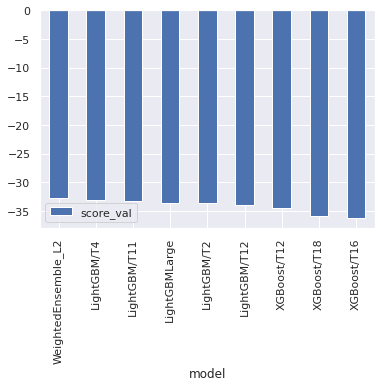

In [80]:
predictor_hpo1.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

In [81]:
# Remember to set all negative values to zero
predictions_hpo1.lt(0).value_counts()

False    6441
True       52
Name: count, dtype: int64

In [82]:
# Set them to zero
predictions_hpo1.iloc[predictions_hpo1<0] = 0
predictions_hpo1.lt(0).value_counts()

False    6493
Name: count, dtype: int64

In [83]:
# Same submitting predictions
submission_hpo1 = pd.read_csv('./sampleSubmission.csv', parse_dates=["datetime"])
submission_hpo1["count"] = predictions_hpo1
submission_hpo1.to_csv("submission_hpo1.csv", index=False)

In [84]:
!kaggle competitions submit -c bike-sharing-demand -f submission_hpo1.csv -m "new features with hyperparameters-1"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 360kB/s]
Successfully submitted to Bike Sharing Demand

In [85]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                        date                 description                          status    publicScore  privateScore  
------------------------------  -------------------  -----------------------------------  --------  -----------  ------------  
submission_hpo1.csv             2023-05-27 20:54:16  new features with hyperparameters-1  complete  0.51957      0.51957       
submission_new_features.csv     2023-05-27 20:47:45  new features                         complete  0.44719      0.44719       
submission.csv                  2023-05-27 20:36:07  first raw submission                 complete  1.79272      1.79272       
submission_hpo3.csv             2023-05-27 19:54:29                                       complete  0.51851      0.51851       
tail: write error: Broken pipe


#### New Score of `0.51957`

### Hyper parameter optimization-2

In [86]:
# Requirements: (Same settings as initial run) For AutoGluon's Tabular Predictions
eval_metric = 'root_mean_squared_error' 
label = 'count'
ignored_columns = ["casual", "registered"]   # Ignored columns while training
train_data = train                           # 'casual' and 'registered' columns are already dropped/ignored
time_limit = 600                             # 10 minutes -> 60*10 = 600 seconds
presets = "optimize_for_deployment" 

In [87]:
import autogluon.core as ag

gbm_options = [{'extra_trees': True, 
                'num_boost_round': ag.space.Int(lower=100, upper=800, default=100),
                'num_leaves': ag.space.Int(2, 30),
                'max_depth': ag.space.Int(2, 30),
                'learning_rate': ag.space.Real(1e-6, 1e-1),
                'n_estimators': ag.space.Int(100, 800),
                'min_child_samples': ag.space.Int(2, 30),
                'subsample': ag.space.Real(0.5, 1, 0.1),
                'ag_args': {'name_suffix': 'XT'}}, {}, 'GBMLarge']


xgb_options = {
                'max_depth': ag.space.Int(2, 30),
                'learning_rate': ag.space.Real(1e-3, 1e-1),
                'n_estimators': ag.space.Int(100, 800),
                'min_child_weight': ag.space.Int(2, 30),
                'colsample_bytree': ag.space.Real(0.3, 1, 0.1)}


rf_options = [{'criterion': 'squared_error',
               'max_depth': ag.space.Int(2, 30),
               'random_state': 0,
               'min_samples_split' : 5,
               'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression']}},
              {'n_estimators':800,'n_jobs':[-1],'max_features':["auto",'sqrt','log2']}]


cat_options = {'objective':'reg:squarederror', 
               'n_estimators': 100,
               'iterations': 4000, 
               'max_depth': ag.space.Int(2, 30),
               'one_hot_max_size': 1, 
               'learning_rate': 0.01,
               'colsample_bylevel': 0.7,
               'l2_leaf_reg': 1,'silent': True,
               'cat_features': 'cat_features'}


hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'XGB': xgb_options,
                   'RF' : rf_options,
                   'CAT' : cat_options
                  }  

num_trials = 20          
search_strategy = 'auto'  
scheduler = 'local'      
hyperparameter_tune_kwargs = { 
    'num_trials': num_trials,
    'scheduler' : scheduler,
    'searcher': search_strategy,
}

predictor_hpo2 = TabularPredictor(label='count', problem_type='regression', eval_metric='root_mean_squared_error',
                                    learner_kwargs={'ignored_columns': ignored_columns}).fit(
                                                                         train_data=train, 
                                                                         time_limit=time_limit,
                                                                         presets=presets, 
                                                                         hyperparameters=hyperparameters, 
                                                                         hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
                                                                         refit_full='best')

No path specified. Models will be saved in: "AutogluonModels/ag-20230527_205418/"
Presets specified: ['optimize_for_deployment']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230527_205418/"
AutoGluon Version:  0.6.2
Python Version:     3.7.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Apr 25 15:24:19 UTC 2023
Train Data Rows:    10739
Train Data Columns: 19
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1865.03 MB
	Train Data (Original)  Memory Usage: 0.86 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 11

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=2 will be ignored. Current value: min_data_in_leaf=20


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=5


 10%|█         | 2/20 [00:01<00:11,  1.63it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=60


 15%|█▌        | 3/20 [00:02<00:14,  1.17it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
 20%|██        | 4/20 [00:02<00:10,  1.53it/s]

[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=22


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=16


 25%|██▌       | 5/20 [00:03<00:09,  1.64it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=37


 30%|███       | 6/20 [00:04<00:10,  1.32it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=40


 35%|███▌      | 7/20 [00:05<00:10,  1.20it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
 40%|████      | 8/20 [00:05<00:08,  1.46it/s]

[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=3 will be ignored. Current value: min_data_in_leaf=41


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=55


 45%|████▌     | 9/20 [00:06<00:08,  1.26it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=38


 50%|█████     | 10/20 [00:07<00:07,  1.36it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=51


 55%|█████▌    | 11/20 [00:07<00:06,  1.36it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=6 will be ignored. Current value: min_data_in_leaf=36


 60%|██████    | 12/20 [00:08<00:05,  1.34it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=52


 65%|██████▌   | 13/20 [00:09<00:04,  1.41it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20


 70%|███████   | 14/20 [00:09<00:04,  1.49it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
 75%|███████▌  | 15/20 [00:10<00:02,  1.70it/s]

[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=45


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=58


 80%|████████  | 16/20 [00:11<00:02,  1.47it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=15


 85%|████████▌ | 17/20 [00:11<00:02,  1.49it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=16


 90%|█████████ | 18/20 [00:12<00:01,  1.44it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=31


 95%|█████████▌| 19/20 [00:13<00:00,  1.49it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=3 will be ignored. Current value: min_data_in_leaf=42


100%|██████████| 20/20 [00:13<00:00,  1.43it/s]
Fitted model: LightGBMXT/T1 ...
	-166.1291	 = Validation score   (-root_mean_squared_error)
	0.28s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBMXT/T2 ...
	-43.8557	 = Validation score   (-root_mean_squared_error)
	0.69s	 = Training   runtime
	0.04s	 = Validation runtime
Fitted model: LightGBMXT/T3 ...
	-39.7728	 = Validation score   (-root_mean_squared_error)
	0.94s	 = Training   runtime
	0.06s	 = Validation runtime
Fitted model: LightGBMXT/T4 ...
	-106.5989	 = Validation score   (-root_mean_squared_error)
	0.29s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBMXT/T5 ...
	-85.9333	 = Validation score   (-root_mean_squared_error)
	0.45s	 = Training   runtime
	0.02s	 = Validation runtime
Fitted model: LightGBMXT/T6 ...
	-40.7217	 = Validation score   (-root_mean_squared_error)
	0.87s	 = Training   runtime
	0.06s	 = Validation runtime
Fitted model: LightGBMXT/T7 ...
	-118.4142	 = Validation

[1000]	valid_set's rmse: 34.4192
[2000]	valid_set's rmse: 34.2173


 15%|█▌        | 3/20 [00:07<00:39,  2.35s/it]

[1000]	valid_set's rmse: 35.8466
[2000]	valid_set's rmse: 34.0418
[3000]	valid_set's rmse: 33.5602
[4000]	valid_set's rmse: 33.3534
[5000]	valid_set's rmse: 33.2098
[6000]	valid_set's rmse: 33.1688
[7000]	valid_set's rmse: 33.1833
[8000]	valid_set's rmse: 33.2217


 25%|██▌       | 5/20 [00:27<01:33,  6.21s/it]

[1000]	valid_set's rmse: 34.2256
[2000]	valid_set's rmse: 34.1462


 40%|████      | 8/20 [00:39<00:50,  4.25s/it]

[1000]	valid_set's rmse: 35.6912
[2000]	valid_set's rmse: 34.5256
[3000]	valid_set's rmse: 34.1726
[4000]	valid_set's rmse: 34.0875
[5000]	valid_set's rmse: 34.0296
[6000]	valid_set's rmse: 34.0236
[7000]	valid_set's rmse: 34.0574


 50%|█████     | 10/20 [01:02<01:09,  6.99s/it]

[1000]	valid_set's rmse: 33.9665
[2000]	valid_set's rmse: 33.283


 55%|█████▌    | 11/20 [01:08<01:01,  6.88s/it]

[1000]	valid_set's rmse: 35.8566


	Ran out of time, early stopping on iteration 1777. Best iteration is:
	[1777]	valid_set's rmse: 34.5718
	Stopping HPO to satisfy time limit...
 55%|█████▌    | 11/20 [01:13<01:00,  6.72s/it]
Fitted model: LightGBM/T1 ...
	-34.1844	 = Validation score   (-root_mean_squared_error)
	2.56s	 = Training   runtime
	0.23s	 = Validation runtime
Fitted model: LightGBM/T2 ...
	-33.7019	 = Validation score   (-root_mean_squared_error)
	1.73s	 = Training   runtime
	0.07s	 = Validation runtime
Fitted model: LightGBM/T3 ...
	-34.7053	 = Validation score   (-root_mean_squared_error)
	1.76s	 = Training   runtime
	0.13s	 = Validation runtime
Fitted model: LightGBM/T4 ...
	-33.1591	 = Validation score   (-root_mean_squared_error)
	14.34s	 = Training   runtime
	1.59s	 = Validation runtime
Fitted model: LightGBM/T5 ...
	-34.5663	 = Validation score   (-root_mean_squared_error)
	1.56s	 = Training   runtime
	0.09s	 = Validation runtime
Fitted model: LightGBM/T6 ...
	-34.1133	 = Validation score   (-root_mea

[1000]	valid_set's rmse: 33.6838


	-33.6776	 = Validation score   (-root_mean_squared_error)
	3.82s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 341.15s of remaining time.
	-32.8468	 = Validation score   (-root_mean_squared_error)
	0.69s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 259.79s ... Best model: "WeightedEnsemble_L2"
Fitting 1 L1 models ...
Fitting model: LightGBM/T2_FULL ...
	1.21s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: LightGBM/T4_FULL ...
	11.71s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: LightGBM/T9_FULL ...
	13.33s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: LightGBM/T11_FULL ...
	4.22s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: XGBoost/T12_FULL ...
	2.15s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: XGBoost/T16_FULL ...
	2.5s	 = Training   runtime
Fitting 1 L1 models ...
Fitting mod

In [88]:
predictor_hpo2.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2 -32.846766       4.988825  57.388769                0.000716           0.688806            2       True          9
1          LightGBM/T4 -33.159107       1.586599  14.343984                1.586599          14.343984            1       True          2
2         LightGBM/T11 -33.261619       0.381732   5.369623                0.381732           5.369623            1       True          4
3        LightGBMLarge -33.677568       0.180919   3.819081                0.180919           3.819081            1       True          8
4          LightGBM/T2 -33.701931       0.067660   1.734136                0.067660           1.734136            1       True          1
5          LightGBM/T9 -34.005827       2.234303  16.189958                2.234303          16.189958        

{'model_types': {'LightGBM/T2': 'LGBModel',
  'LightGBM/T4': 'LGBModel',
  'LightGBM/T9': 'LGBModel',
  'LightGBM/T11': 'LGBModel',
  'XGBoost/T12': 'XGBoostModel',
  'XGBoost/T16': 'XGBoostModel',
  'XGBoost/T18': 'XGBoostModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBM/T2': -33.70193065613448,
  'LightGBM/T4': -33.15910680426717,
  'LightGBM/T9': -34.005826942541766,
  'LightGBM/T11': -33.26161916778297,
  'XGBoost/T12': -34.54806161739418,
  'XGBoost/T16': -36.17045492773235,
  'XGBoost/T18': -35.816694065319425,
  'LightGBMLarge': -33.67756790781677,
  'WeightedEnsemble_L2': -32.84676618955348},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'LightGBM/T2': '/root/nd009t-c1-intro-to-ml-project-starter/Project Stand Out/AutogluonModels/ag-20230527_205418/models/LightGBM/T2/',
  'LightGBM/T4': '/root/nd009t-c1-intro-to-ml-project-starter/Project Stand Out/AutogluonModels/ag-20230527_205418/models/LightGB

In [89]:
# Leaderboard dataframe
leaderboard_hpo2 = pd.DataFrame(predictor_hpo2.leaderboard(silent=True))
leaderboard_hpo2

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-32.846766,4.988825,57.388769,0.000716,0.688806,2,True,9
1,LightGBM/T4,-33.159107,1.586599,14.343984,1.586599,14.343984,1,True,2
2,LightGBM/T11,-33.261619,0.381732,5.369623,0.381732,5.369623,1,True,4
3,LightGBMLarge,-33.677568,0.180919,3.819081,0.180919,3.819081,1,True,8
4,LightGBM/T2,-33.701931,0.067660,1.734136,0.067660,1.734136,1,True,1
5,LightGBM/T9,-34.005827,2.234303,16.189958,2.234303,16.189958,1,True,3
6,XGBoost/T12,-34.548062,0.112492,3.460101,0.112492,3.460101,1,True,5
7,XGBoost/T18,-35.816694,0.322346,5.959743,0.322346,5.959743,1,True,7
8,XGBoost/T16,-36.170455,0.102057,5.823337,0.102057,5.823337,1,True,6


In [90]:
predictions_hpo2 = predictor_hpo2.predict(test)
predictions_hpo2.head()

0    19.255873
1     4.363661
2     1.637604
3     2.564686
4     2.460362
Name: count, dtype: float32

In [91]:
predictions_hpo2.describe()

count    6493.000000
mean      188.618393
std       167.970718
min       -17.741751
25%        46.590557
50%       147.598358
75%       283.974701
max       749.083069
Name: count, dtype: float64

<AxesSubplot:xlabel='model'>

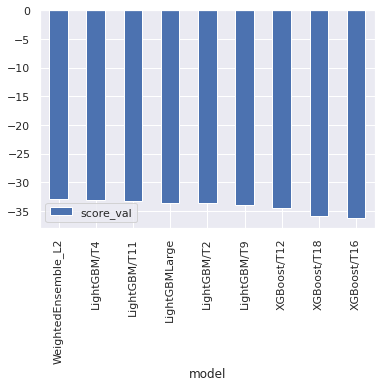

In [92]:
predictor_hpo2.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

In [93]:
# Remember to set all negative values to zero
predictions_hpo2.lt(0).value_counts()

False    6445
True       48
Name: count, dtype: int64

In [94]:
# Set them to zero
predictions_hpo2.iloc[predictions_hpo2<0] = 0
predictions_hpo2.lt(0).value_counts()

False    6493
Name: count, dtype: int64

In [95]:
# Same submitting predictions
submission_hpo2 = pd.read_csv('./sampleSubmission.csv', parse_dates=["datetime"])
submission_hpo2["count"] = predictions_hpo2
submission_hpo2.to_csv("submission_hpo2.csv", index=False)

In [96]:
!kaggle competitions submit -c bike-sharing-demand -f submission_hpo2.csv -m "new features with hyperparameters-2"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 399kB/s]
Successfully submitted to Bike Sharing Demand

In [97]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                        date                 description                          status    publicScore  privateScore  
------------------------------  -------------------  -----------------------------------  --------  -----------  ------------  
submission_hpo2.csv             2023-05-27 21:00:19  new features with hyperparameters-2  pending                              
submission_hpo1.csv             2023-05-27 20:54:16  new features with hyperparameters-1  complete  0.51957      0.51957       
submission_new_features.csv     2023-05-27 20:47:45  new features                         complete  0.44719      0.44719       
submission.csv                  2023-05-27 20:36:07  first raw submission                 complete  1.79272      1.79272       
tail: write error: Broken pipe


#### New Score of `0.51782`

### Hyper parameter optimization-3

In [98]:
# Requirements: (Same settings as initial run) For AutoGluon's Tabular Predictions
eval_metric = 'root_mean_squared_error' 
label = 'count'
ignored_columns = ["casual", "registered"]   # Ignored columns while training
train_data = train                           # 'casual' and 'registered' columns are already dropped/ignored
time_limit = 600                             # 10 minutes -> 60*10 = 600 seconds
presets = "optimize_for_deployment" 

In [99]:
import autogluon.core as ag

gbm_options = [{'extra_trees': True, 
                'num_boost_round': ag.space.Int(lower=100, upper=800, default=100),
                'num_leaves': ag.space.Int(2, 30),
                'max_depth': ag.space.Int(2, 30),
                'learning_rate': ag.space.Real(1e-6, 1e-1),
                'n_estimators': ag.space.Int(100, 800),
                'min_child_samples': ag.space.Int(2, 30),
                'subsample': ag.space.Real(0.5, 1, 0.1),
                'ag_args': {'name_suffix': 'XT'}}, {}, 'GBMLarge']


xgb_options = [{
                'max_depth': ag.space.Int(2, 30),
                'learning_rate': ag.space.Real(1e-3, 1e-1),
                'n_estimators': ag.space.Int(100, 800),
                'min_child_weight': ag.space.Int(2, 30),
                'colsample_bytree': ag.space.Real(0.3, 1, 0.1)}]


rf_options = [{'criterion': 'squared_error',
               'max_depth': ag.space.Int(2, 30),
               'random_state': 0,
               'min_samples_split' : 5,
               'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression']}},
              {'n_estimators':800,'n_jobs':[-1],'max_features':["auto",'sqrt','log2']}]

cat_options = {'objective':'reg:squarederror', 
               'n_estimators': 100,
               'iterations': 4000, 
               'max_depth': ag.space.Int(2, 30),
               'one_hot_max_size': 1, 
               'learning_rate': 0.01,
               'colsample_bylevel': 0.7,
               'l2_leaf_reg': 1,'silent': True,
               'cat_features': 'cat_features'}

knn_options = [{'weights': 'uniform', 
                'ag_args': {'name_suffix': 'Unif'}}, 
               {'weights': 'distance', 'ag_args': {'name_suffix': 'Dist'}},
               {'n_jobs': -1, 'n_neighbors': 5}]

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'XGB': xgb_options,
                   'RF' : rf_options,
                   'CAT' : cat_options,
                   'KNN' : knn_options,
                  }  

num_trials = 20          
search_strategy = 'auto'  
scheduler = 'local'      
hyperparameter_tune_kwargs = { 
    'num_trials': num_trials,
    'scheduler' : scheduler,
    'searcher': search_strategy,
}

predictor_hpo3 = TabularPredictor(label='count', problem_type='regression', eval_metric='root_mean_squared_error',
                                    learner_kwargs={'ignored_columns': ignored_columns}).fit(
                                                                         train_data=train, 
                                                                         time_limit=time_limit,
                                                                         presets=presets, 
                                                                         hyperparameters=hyperparameters, 
                                                                         hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
                                                                         refit_full='best')

No path specified. Models will be saved in: "AutogluonModels/ag-20230527_210021/"
Presets specified: ['optimize_for_deployment']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230527_210021/"
AutoGluon Version:  0.6.2
Python Version:     3.7.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Apr 25 15:24:19 UTC 2023
Train Data Rows:    10739
Train Data Columns: 19
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1897.54 MB
	Train Data (Original)  Memory Usage: 0.86 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 11

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=2 will be ignored. Current value: min_data_in_leaf=20


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=5


 10%|█         | 2/20 [00:01<00:10,  1.66it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=60


 15%|█▌        | 3/20 [00:02<00:14,  1.18it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
 20%|██        | 4/20 [00:02<00:10,  1.53it/s]

[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=22


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=16


 25%|██▌       | 5/20 [00:03<00:09,  1.64it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=37


 30%|███       | 6/20 [00:04<00:10,  1.31it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=40


 35%|███▌      | 7/20 [00:05<00:10,  1.20it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
 40%|████      | 8/20 [00:05<00:08,  1.45it/s]

[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=3 will be ignored. Current value: min_data_in_leaf=41


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=55


 45%|████▌     | 9/20 [00:06<00:08,  1.25it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=38


 50%|█████     | 10/20 [00:07<00:07,  1.34it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=51


 55%|█████▌    | 11/20 [00:07<00:06,  1.35it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=6 will be ignored. Current value: min_data_in_leaf=36


 60%|██████    | 12/20 [00:08<00:06,  1.32it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=52


 65%|██████▌   | 13/20 [00:09<00:05,  1.39it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20


 70%|███████   | 14/20 [00:09<00:04,  1.49it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
 75%|███████▌  | 15/20 [00:10<00:02,  1.70it/s]

[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=45


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=58


 80%|████████  | 16/20 [00:11<00:02,  1.50it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=15


 85%|████████▌ | 17/20 [00:11<00:02,  1.50it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=16


 90%|█████████ | 18/20 [00:12<00:01,  1.45it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=31


 95%|█████████▌| 19/20 [00:13<00:00,  1.50it/s]/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=3 will be ignored. Current value: min_data_in_leaf=42


100%|██████████| 20/20 [00:13<00:00,  1.43it/s]
Fitted model: LightGBMXT/T1 ...
	-166.1291	 = Validation score   (-root_mean_squared_error)
	0.29s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBMXT/T2 ...
	-43.8557	 = Validation score   (-root_mean_squared_error)
	0.67s	 = Training   runtime
	0.04s	 = Validation runtime
Fitted model: LightGBMXT/T3 ...
	-39.7728	 = Validation score   (-root_mean_squared_error)
	0.92s	 = Training   runtime
	0.06s	 = Validation runtime
Fitted model: LightGBMXT/T4 ...
	-106.5989	 = Validation score   (-root_mean_squared_error)
	0.3s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBMXT/T5 ...
	-85.9333	 = Validation score   (-root_mean_squared_error)
	0.45s	 = Training   runtime
	0.02s	 = Validation runtime
Fitted model: LightGBMXT/T6 ...
	-40.7217	 = Validation score   (-root_mean_squared_error)
	0.87s	 = Training   runtime
	0.06s	 = Validation runtime
Fitted model: LightGBMXT/T7 ...
	-118.4142	 = Validation 

[1000]	valid_set's rmse: 34.4192
[2000]	valid_set's rmse: 34.2173


 15%|█▌        | 3/20 [00:07<00:39,  2.34s/it]

[1000]	valid_set's rmse: 35.8466
[2000]	valid_set's rmse: 34.0418
[3000]	valid_set's rmse: 33.5602
[4000]	valid_set's rmse: 33.3534
[5000]	valid_set's rmse: 33.2098
[6000]	valid_set's rmse: 33.1688
[7000]	valid_set's rmse: 33.1833
[8000]	valid_set's rmse: 33.2217


 25%|██▌       | 5/20 [00:28<01:39,  6.64s/it]

[1000]	valid_set's rmse: 34.2256
[2000]	valid_set's rmse: 34.1462


 40%|████      | 8/20 [00:39<00:49,  4.13s/it]

[1000]	valid_set's rmse: 35.6912
[2000]	valid_set's rmse: 34.5256
[3000]	valid_set's rmse: 34.1726
[4000]	valid_set's rmse: 34.0875


	Ran out of time, early stopping on iteration 5050. Best iteration is:
	[4624]	valid_set's rmse: 34.0206


[5000]	valid_set's rmse: 34.0296


	Stopping HPO to satisfy time limit...
 40%|████      | 8/20 [00:54<01:21,  6.82s/it]
Fitted model: LightGBM/T1 ...
	-34.1844	 = Validation score   (-root_mean_squared_error)
	2.59s	 = Training   runtime
	0.23s	 = Validation runtime
Fitted model: LightGBM/T2 ...
	-33.7019	 = Validation score   (-root_mean_squared_error)
	1.72s	 = Training   runtime
	0.06s	 = Validation runtime
Fitted model: LightGBM/T3 ...
	-34.7053	 = Validation score   (-root_mean_squared_error)
	1.74s	 = Training   runtime
	0.12s	 = Validation runtime
Fitted model: LightGBM/T4 ...
	-33.1591	 = Validation score   (-root_mean_squared_error)
	14.34s	 = Training   runtime
	1.82s	 = Validation runtime
Fitted model: LightGBM/T5 ...
	-34.5663	 = Validation score   (-root_mean_squared_error)
	2.28s	 = Training   runtime
	0.11s	 = Validation runtime
Fitted model: LightGBM/T6 ...
	-34.1133	 = Validation score   (-root_mean_squared_error)
	5.03s	 = Training   runtime
	0.37s	 = Validation runtime
Fitted model: LightGBM/T7 ...
	

[1000]	valid_set's rmse: 33.6838


	-33.6776	 = Validation score   (-root_mean_squared_error)
	3.62s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 407.76s of remaining time.
	-32.8826	 = Validation score   (-root_mean_squared_error)
	0.87s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 193.4s ... Best model: "WeightedEnsemble_L2"
Fitting 1 L1 models ...
Fitting model: LightGBM/T2_FULL ...
	1.21s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: LightGBM/T4_FULL ...
	12.11s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: LightGBM/T9_FULL ...
	10.03s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: XGBoost/T2_FULL ...
	1.78s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: XGBoost/T12_FULL ...
	2.14s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: LightGBMLarge_FULL ...
	2.91s	 = Training   runtime
Fitting model: WeightedEnsemble_L2_

In [100]:
predictor_hpo3.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2 -32.882554       3.711376  38.848705                0.000701           0.866395            2       True          7
1          LightGBM/T4 -33.159107       1.821356  14.335613                1.821356          14.335613            1       True          2
2        LightGBMLarge -33.677568       0.183369   3.623457                0.183369           3.623457            1       True          6
3          LightGBM/T2 -33.701931       0.064503   1.718625                0.064503           1.718625            1       True          1
4          LightGBM/T9 -34.020553       1.484471  11.543593                1.484471          11.543593            1       True          3
5          XGBoost/T12 -34.548062       0.111655   3.765997                0.111655           3.765997        

{'model_types': {'LightGBM/T2': 'LGBModel',
  'LightGBM/T4': 'LGBModel',
  'LightGBM/T9': 'LGBModel',
  'XGBoost/T2': 'XGBoostModel',
  'XGBoost/T12': 'XGBoostModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBM/T2': -33.70193065613448,
  'LightGBM/T4': -33.15910680426717,
  'LightGBM/T9': -34.02055349443172,
  'XGBoost/T2': -38.020277772844075,
  'XGBoost/T12': -34.54806161739418,
  'LightGBMLarge': -33.67756790781677,
  'WeightedEnsemble_L2': -32.88255426418729},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'LightGBM/T2': '/root/nd009t-c1-intro-to-ml-project-starter/Project Stand Out/AutogluonModels/ag-20230527_210021/models/LightGBM/T2/',
  'LightGBM/T4': '/root/nd009t-c1-intro-to-ml-project-starter/Project Stand Out/AutogluonModels/ag-20230527_210021/models/LightGBM/T4/',
  'LightGBM/T9': '/root/nd009t-c1-intro-to-ml-project-starter/Project Stand Out/AutogluonModels/ag-20230527_210021/models/LightGBM/T9

In [101]:
# Leaderboard dataframe
leaderboard_hpo3 = pd.DataFrame(predictor_hpo3.leaderboard(silent=True))
leaderboard_hpo3

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-32.882554,3.711376,38.848705,0.000701,0.866395,2,True,7
1,LightGBM/T4,-33.159107,1.821356,14.335613,1.821356,14.335613,1,True,2
2,LightGBMLarge,-33.677568,0.183369,3.623457,0.183369,3.623457,1,True,6
3,LightGBM/T2,-33.701931,0.064503,1.718625,0.064503,1.718625,1,True,1
4,LightGBM/T9,-34.020553,1.484471,11.543593,1.484471,11.543593,1,True,3
5,XGBoost/T12,-34.548062,0.111655,3.765997,0.111655,3.765997,1,True,5
6,XGBoost/T2,-38.020278,0.045321,2.995026,0.045321,2.995026,1,True,4


In [102]:
predictions_hpo3 = predictor_hpo3.predict(test)
predictions_hpo3.head()

0    18.153532
1     3.982770
2     1.676779
3     2.113017
4     2.031560
Name: count, dtype: float32

In [103]:
predictions_hpo3.describe()

count    6493.000000
mean      188.610077
std       167.879684
min       -20.741684
25%        46.514725
50%       147.736572
75%       284.942017
max       757.884277
Name: count, dtype: float64

<AxesSubplot:xlabel='model'>

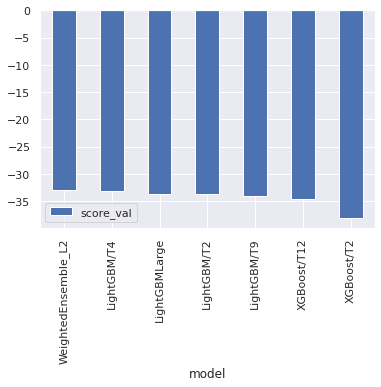

In [104]:
predictor_hpo3.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

In [105]:
# Remember to set all negative values to zero
predictions_hpo3.lt(0).value_counts()

False    6429
True       64
Name: count, dtype: int64

In [106]:
# Set them to zero
predictions_hpo3.iloc[predictions_hpo3<0] = 0
predictions_hpo3.lt(0).value_counts()

False    6493
Name: count, dtype: int64

In [107]:
# Same submitting predictions
submission_hpo3 = pd.read_csv('./sampleSubmission.csv', parse_dates=["datetime"])
submission_hpo3["count"] = predictions_hpo3
submission_hpo3.to_csv("submission_hpo3.csv", index=False)

In [108]:
!kaggle competitions submit -c bike-sharing-demand -f submission_hpo3.csv -m "new features with hyperparameters-3"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 331kB/s]
Successfully submitted to Bike Sharing Demand

In [109]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                        date                 description                          status    publicScore  privateScore  
------------------------------  -------------------  -----------------------------------  --------  -----------  ------------  
submission_hpo3.csv             2023-05-27 21:04:43  new features with hyperparameters-3  complete  0.52776      0.52776       
submission_hpo2.csv             2023-05-27 21:00:19  new features with hyperparameters-2  complete  0.51782      0.51782       
submission_hpo1.csv             2023-05-27 20:54:16  new features with hyperparameters-1  complete  0.51957      0.51957       
submission_new_features.csv     2023-05-27 20:47:45  new features                         complete  0.44719      0.44719       
tail: write error: Broken pipe


#### New Score of `0.52776`

## Other models Training for Project Stand Out

### XGBoost

In [110]:
rf_columns = [
    'weather_1', 'weather_2', 'weather_3', 'weather_4', 'temp', 'windspeed',
    'workingday', 'season_1', 'season_2', 'season_3', 'season_4', 'holiday',
    'hour',
]
gb_columns =[
    'weather_1', 'weather_2', 'weather_3', 'weather_4', 'temp', 'humidity', 'windspeed',
    'workingday', 'season_1', 'season_2', 'season_3', 'season_4', 'holiday',
    'hour','year', 
]

In [111]:
rf_x_train=train[rf_columns].values
rf_x_test=test[rf_columns].values

gb_x_train=train[gb_columns].values
gb_x_test=test[gb_columns].values

In [112]:
y_casual=train['casual'].apply(lambda x: np.log1p(x)).values
y_registered=train['registered'].apply(lambda x: np.log1p(x)).values
y=train['count'].apply(lambda x: np.log1p(x)).values

In [113]:
xgb_params = {'random_state': 42, 
              'n_estimators': 200, 
              'max_depth': 5, 
              'learning_rate': 0.1}

XGB1 = xgb.XGBRegressor(**xgb_params)
XGB1.fit(gb_x_train,y_casual)
print("model score for prediting casual count:",XGB1.score(gb_x_train,y_casual))

XGB2 = xgb.XGBRegressor(**xgb_params)
XGB2.fit(gb_x_train,y_registered)
print("model score for prediting registered count:",XGB2.score(gb_x_train,y_registered))

XGB3 = xgb.XGBRegressor(**xgb_params)
XGB3.fit(gb_x_train,y)
print("model score for prediting count:",XGB3.score(gb_x_train,y))

model score for prediting casual count: 0.9155841423397277
model score for prediting registered count: 0.9629298485997684
model score for prediting count: 0.9640628045360475


<Figure size 1080x864 with 0 Axes>

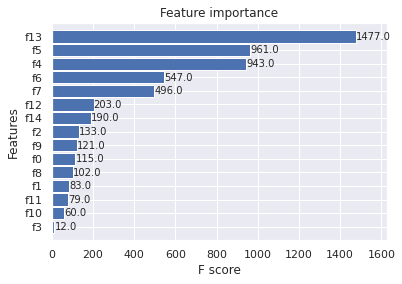

In [114]:
from xgboost import plot_importance, plot_tree
fig = plt.figure(figsize=(15,12))
fig = plot_importance(XGB3, height=0.9,max_num_features = 25)
plt.show()

In [115]:
def prediction(x_test, models):
    prediction = []
    for model in models:
        pre = model.predict(x_test)
        pre = np.expm1(pre)
        prediction.append(pre)
    return sum(prediction)

pred_xgb = prediction(gb_x_test, models=[XGB1, XGB2])

In [116]:
pred_xgb

array([ 10.262078 ,   4.48667  ,   2.2565615, ..., 105.56177  ,
        86.265976 ,  52.68291  ], dtype=float32)

In [117]:
submit = pd.DataFrame({'datetime':x_date,'count':pred_xgb})
submit.to_csv('submission-XGB.csv',index=False)

In [118]:
!kaggle competitions submit -c bike-sharing-demand -f submission-XGB.csv -m "XGB submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 472kB/s]
Successfully submitted to Bike Sharing Demand

In [119]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                        date                 description                          status    publicScore  privateScore  
------------------------------  -------------------  -----------------------------------  --------  -----------  ------------  
submission-XGB.csv              2023-05-27 21:04:54  XGB submission                       complete  0.38604      0.38604       
submission_hpo3.csv             2023-05-27 21:04:43  new features with hyperparameters-3  complete  0.52776      0.52776       
submission_hpo2.csv             2023-05-27 21:00:19  new features with hyperparameters-2  complete  0.51782      0.51782       
submission_hpo1.csv             2023-05-27 20:54:16  new features with hyperparameters-1  complete  0.51957      0.51957       
tail: write error: Broken pipe


#### New Score of `0.38604`

### Random Forest Regression

In [120]:
train.drop(['casual','registered'],axis=1,inplace=True)

In [121]:
x_train,x_test,y_train,y_test=train_test_split(train.drop('count',axis=1),train['count'],test_size=0.25,random_state=42)

In [122]:
no_of_test=[500]
params_dict={'n_estimators':no_of_test,'n_jobs':[-1],'max_features':["auto",'sqrt','log2']}
clf_rf=GridSearchCV(estimator=RandomForestRegressor(),param_grid=params_dict,scoring='neg_mean_squared_log_error')
clf_rf.fit(x_train,y_train)
pred=clf_rf.predict(x_test)
print((np.sqrt(mean_squared_log_error(pred,y_test))))

0.31848521162022797


In [123]:
clf_rf.best_params_

{'max_features': 'auto', 'n_estimators': 500, 'n_jobs': -1}

In [124]:
pred_f=clf_rf.predict(test)
pred_f

array([ 12.508,   5.106,   3.282, ..., 163.356, 107.804,  71.05 ])

In [125]:
submit = pd.DataFrame({'datetime':x_date,'count':pred_f})
submit.to_csv('submission-RandomForest.csv',index=False)

In [126]:
!kaggle competitions submit -c bike-sharing-demand -f submission-RandomForest.csv -m "RandomForest submission"

100%|█████████████████████████████████████████| 174k/174k [00:00<00:00, 313kB/s]
Successfully submitted to Bike Sharing Demand

In [127]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                        date                 description                          status    publicScore  privateScore  
------------------------------  -------------------  -----------------------------------  --------  -----------  ------------  
submission-RandomForest.csv     2023-05-27 21:06:46  RandomForest submission              complete  0.47632      0.47632       
submission-XGB.csv              2023-05-27 21:04:54  XGB submission                       complete  0.38604      0.38604       
submission_hpo3.csv             2023-05-27 21:04:43  new features with hyperparameters-3  complete  0.52776      0.52776       
submission_hpo2.csv             2023-05-27 21:00:19  new features with hyperparameters-2  complete  0.51782      0.51782       
tail: write error: Broken pipe


#### New Score of `0.38604`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

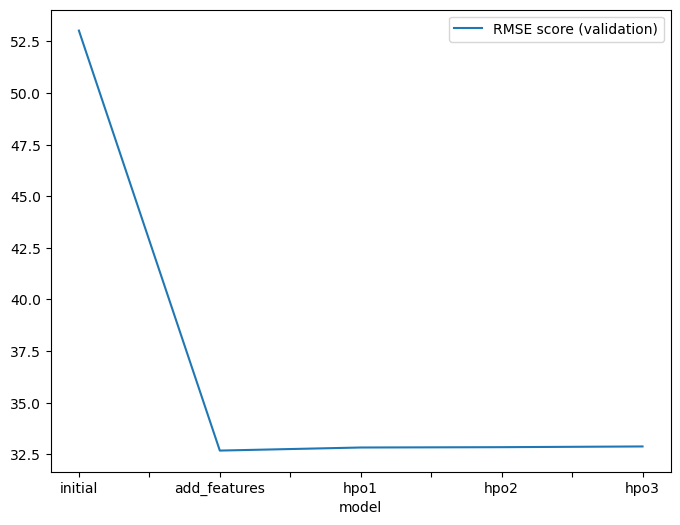

In [2]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features","hpo1","hpo2","hpo3"],
        "RMSE score (validation)": [53.021, 32.682, 32.831, 32.847, 32.882]
    }
).plot(x="model", y="RMSE score (validation)", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

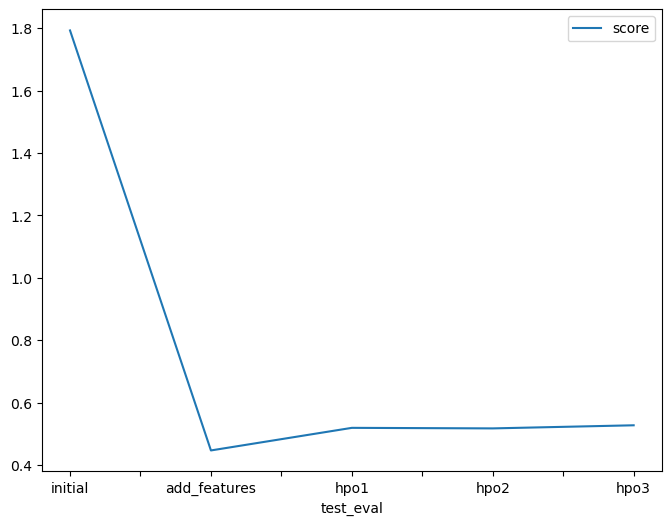

In [3]:
# Take the kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo1", "hpo2", "hpo3"],
        "score": [1.79272, 0.44719, 0.51957, 0.51782, 0.52776]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [5]:
# The 3 hyperparameters along with 2 more models we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo1_ag", "hpo2_ag", "hpo3_ag", 
              "hypo_xgb", "hypo_rf"],
    "hpo1": ["prescribed_values", "prescribed_values", "prescribed_values", 
             "prescribed_values", "prescribed_values", "prescribed_values", 
             "prescribed_values"],
    "hpo2": ["prescribed_values", "prescribed_values", "GBM, XGB, RF", 
             "hpo1 + CAT", "hpo2 + KNN", "max_depth","n_jobs"],
    "hpo3": ["presets: 'high quality'", "presets: 'high quality'", 
             "presets: 'optimize_for_deployment", "presets: 'optimize_for_deployment", 
             "presets: 'optimize_for_deployment", "learning_rate", "max_features"],
    "score": [1.79438, 0.44719, 0.51957, 0.51782, 0.52776, 0.38604, 0.47632]
})

,model,hpo1,hpo2,hpo3,score
0,initial,prescribed_values,prescribed_values,presets: 'high quality',1.79438
1,add_features,prescribed_values,prescribed_values,presets: 'high quality',0.44719
2,hpo1_ag,prescribed_values,"GBM, XGB, RF",presets: 'optimize_for_deployment,0.51957
3,hpo2_ag,prescribed_values,hpo1 + CAT,presets: 'optimize_for_deployment,0.51782
4,hpo3_ag,prescribed_values,hpo2 + KNN,presets: 'optimize_for_deployment,0.52776
5,hypo_xgb,prescribed_values,max_depth,learning_rate,0.38604
6,hypo_rf,prescribed_values,n_jobs,max_features,0.47632


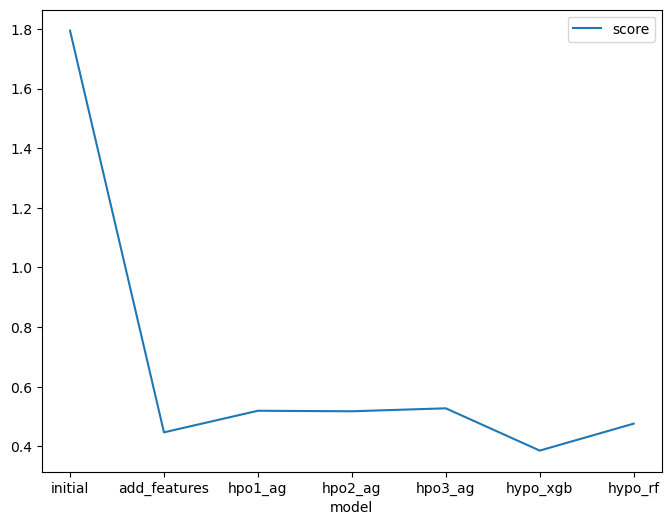

In [11]:
pd.DataFrame({
    "model": ["initial", "add_features", "hpo1_ag", "hpo2_ag", "hpo3_ag", 
              "hypo_xgb", "hypo_rf"],
    "score": [1.79438, 0.44719, 0.51957, 0.51782, 0.52776, 0.38604, 0.47632]
}).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('all_models_test_score.png')

## Conclusion:

The top-ranked model was the (`added features`) **`XGBoost`** model with `hyperparameters`, with the best Kaggle score of **`0.38604`** (on test dataset).